Simulation script to evaluate how well we can recover feature representation from Gaussian process search.   
Author: Allen Ross

## Setup

In [1]:
# Libraries
import gpflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# import helper_functions as hfns
from helper_functions import *
import os
import itertools
# from tqdm import tdqm
from joblib import Parallel, delayed
import time
import pickle
import glob
import re

# Options
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
# tf.config.set_visible_devices([], 'GPU')
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Functions
def sim_data(rate=12, num_units=30, fixed_num=False,
             include_output=False, kern_out=None,
             eps=0, set_seed=True):
    # Set random seed
    if set_seed:
        np.random.seed(9102)

    # Assign treatment group to each unit
    # treat_group = np.repeat([0,1], num_units/2)
    treat_group = np.random.binomial(n=1, p=0.5, size=num_units)

    # Sample number of observations for each unit
    if fixed_num:
        num_obs = np.repeat(rate, num_units)
    else:
        num_obs = np.random.poisson(lam=rate, size=num_units)

    # Sample from uniform distribution for observation times
    x = np.concatenate(
        [np.sort(np.round(np.random.uniform(low=0, high=12, size=i), 1)) for i in num_obs],
        axis=0
    )

    # Put unit ID and observation time together
    df = np.array([np.repeat(np.arange(num_units), num_obs),
                   np.repeat(treat_group, num_obs),
                   x]).T

    df = pd.DataFrame(
        df,
        columns=['id', 'treat', 'time']
    )

    # Standardize continuous variable
    df.time = (df.time - 6) / np.sqrt((1/12.)*(12**2))
    
    # return df

    if include_output and kern_out is not None:

        for k in kern_out.keys():
            # Simulate output
            f_ = np.random.multivariate_normal(
                mean=np.zeros_like(df.iloc[:, 0]).flatten(),
                cov=kern_out[k]['model'](df) + 1e-6 * np.eye(df.shape[0]),
                size=1
            )[0]

            # Add noise
            df[k] = f_ + np.random.normal(loc=0, scale=np.sqrt(eps), size=len(f_))

    return df


def run_simulation(rate, epsilon, units, iters, kernel_list):
    
    tf.get_logger().setLevel('ERROR')
    
    # Prep output dataset
    sim_out = pd.DataFrame()

    # Build temporary simulated data
    temp_df = sim_data(
        rate=rate,
        num_units=units,
        include_output=True,
        kern_out=kernel_dictionary,
        set_seed=False,
        eps=epsilon
    )

    # Run kernel search process
    for i in range(4):
        search_out = split_kernel_search(
            X=temp_df[['id', 'treat', 'time']],
            Y=temp_df.drop(columns=['id', 'treat', 'time']).iloc[:, i],
            kern_list=kernel_list,
            cat_vars=[0, 1],
            unit_idx=0,
            max_depth=5,
            early_stopping=True,
            prune=True,
            keep_all=False,
            keep_only_best=True,
            lik='gaussian',
            random_seed=9102,
            metric_diff=1  # 3,  # 0
            )

        # Save resulting kernels and information
        cur_out = pd.DataFrame({
            'rate': [rate],  # 4*[r],
            'eps': [epsilon],  # 4*[eps],
            'units': [units],  # 4*[u],
            'iter': [iters],  # 4*[i],
            'output': ['y'+str(i)],  # ['y1', 'y2', 'y3', 'y4'],
            'kernel': [search_out['best_model']],  # [x['best_model'] for x in search_out],
            'model': [search_out['models'][search_out['best_model']]]
            # [x['models'][x['best_model']] for x in search_out]
        })

        sim_out = pd.concat([sim_out, cur_out])
        # print(f"Finished rate {r} with {u} units and epsilon {eps}")
        # print(f"Took {round((time.time() - start_time)/60, 1)} minutes")

    return sim_out.reset_index(drop=True)

## Kernel specifications

In [3]:
# First kernel is just a simple time varying covariance structure + unit offset
k1 = (gpflow.kernels.Matern12(variance=1.0,
                              lengthscales=1.0,
                              active_dims=[2]) +
      Categorical(variance=2.0,
                       active_dims=[0]))

# Second kernel is time varying unit specific effect + periodic overall effect
k2 = (gpflow.kernels.Matern12(variance=1.0,
                              lengthscales=0.5,
                              active_dims=[2]) *
      Categorical(active_dims=[0], variance=1.0) +
      gpflow.kernels.Periodic(
          base_kernel=gpflow.kernels.SquaredExponential(
              variance=2.0, active_dims=[2]),
          period=0.5))

# Third kernel is random unit specific effect + treatment effect
k3 = (Categorical(active_dims=[0], variance=1.0) +
      Categorical(active_dims=[1], variance=1.0) *
      gpflow.kernels.Linear(variance=2.0,
                            active_dims=[2]))

# Fourth kernel is nonlinear random treatment effect over time +
# nonlinear individual effect over time
k4 = (Categorical(active_dims=[1], variance=1.5) *
      gpflow.kernels.Polynomial(degree=3,
                                offset=1,#0.1,
                                variance=1.0,
                                active_dims=[2]) +
      Categorical(active_dims=[0], variance=1.5) *
      gpflow.kernels.SquaredExponential(variance=1.0,
                                        lengthscales=0.5,
                                        active_dims=[2]))

# Kernel dictionary
kernel_dictionary = {
    'y1': {'model': k1},
    'y2': {'model': k2},
    'y3': {'model': k3},
    'y4': {'model': k4}
}

# Kernel list
kernel_list = [
    Lin(),
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern12(),
    gpflow.kernels.Polynomial(),
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
]

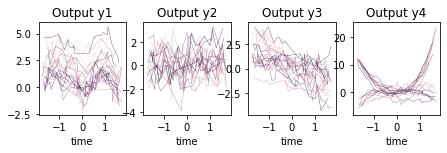

In [4]:
# Sample from kernels to inspect potential output
samp_df = sim_data(rate=20, #20,
                   num_units=20, #50,
                   fixed_num=True,
                   include_output=True,
                   kern_out=kernel_dictionary,
                   set_seed=True,
                   eps=0.3)

# Plot resulting output
f, axs = plt.subplots(1, len(kernel_dictionary), figsize=(7.2, 1.7))
for i, k in enumerate(kernel_dictionary.keys()):
    p = sns.lineplot(data=samp_df,
                     x='time',
                     y=k,
                     hue='id',
                     legend=False,
                     alpha=0.9,
                     linewidth=0.35,
                     ax=axs[i])
    p.set_title(f'Output {k}')
    #if i != 0:
    p.set_ylabel('')
    p.plot()

In [5]:
search_example = GPKernelSearch(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df.drop(columns=['id', 'treat', 'time']),
    unit_col="id",
    categorical_vars=["id", "treat"]
)

search_example.run_search(
    kernels=kernel_list,
    random_seed=9102
)

Kernel search: 100%|████████████████████████████████████████████████████████████████████████████| 4/4 [05:24<00:00, 81.14s/it]


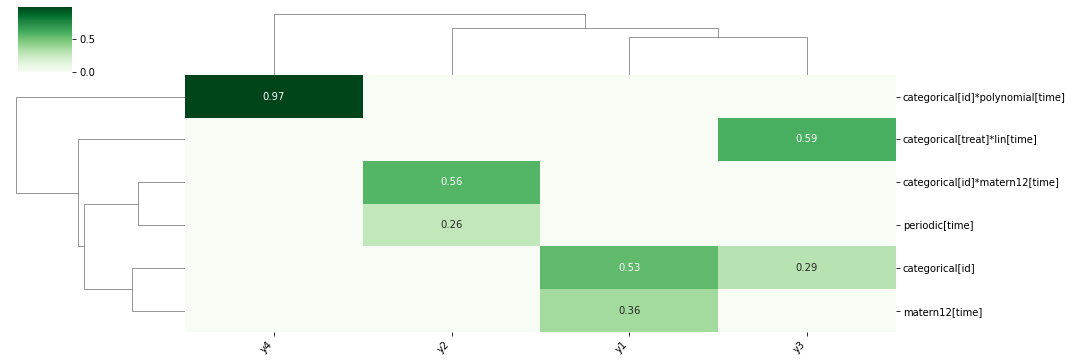

In [6]:
search_example.plot_heatmap()

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*polynomial[time] (97.4%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (2.6%)'}, xlabel='time'>],
       dtype=object))

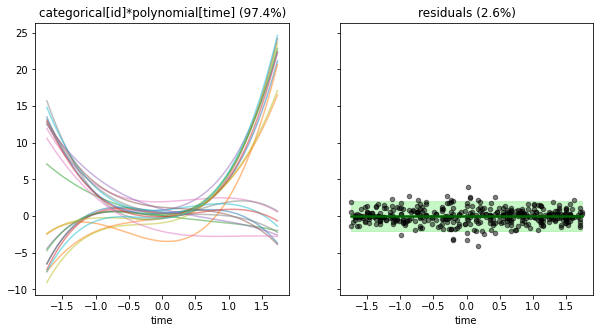

In [10]:
search_example.plot_parts("y4", "time")

In [5]:
%%time
y2_test = full_kernel_search(
    X=samp_df[["id", "treat", "time"]],
    Y=samp_df.y2,
    kern_list=kernel_list,
    cat_vars=[0, 1],
    verbose=True,
    random_seed=9102,
    keep_only_best=False
    # k=Categorical(active_dims=[0])*gpflow.kernels.Matern12(active_dims=[2]) + gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(active_dims=[2]))
)

Working on depth 1 now
Pruning now
Best model for depth 1 is categorical[0]
-----------

Working on depth 2 now
Pruning now
Current kernel component: categorical[0]*matern12[2]
Currently dealing with product terms!
New kernel piece being tested: categorical[0]
Model about to be fit: categorical[0]
categorical[0] has already been fit. Skipping!
New kernel piece being tested: matern12[2]
Model about to be fit: matern12[2]
matern12[2] has already been fit. Skipping!
New best log likelihood: -1589.7537578069205
Model: matern12, BIC: 3193.32
Best model for depth 2 is categorical[0]*matern12[2]
-----------

Working on depth 3 now
Pruning now
Current kernel component: categorical[0]*matern12[2]
Currently dealing with product terms!
New kernel piece being tested: categorical[0]
Model about to be fit: categorical[0]+periodic[2]
categorical[0]+periodic[2] has already been fit. Skipping!
New kernel piece being tested: matern12[2]
Model about to be fit: matern12[2]+periodic[2]
New best log likelih

In [15]:
y2_test["models"]["categorical[0]*matern12[2]+matern12[2]"]

{'kernel': <gpflow.kernels.base.Sum object at 0x28af4a2e0>
╒════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                   │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].kernels[0].variance     │ Parameter │ Softplus    │ Uniform │ True        │ ()      │ float64 │ 1.0409  │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].kernels[1].variance     │ Parameter │ Softplus    │ Uniform │ False       │ ()      │ float64 │ 1       │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].kernels[1].lengthscales │ Parameter │ Softplus    │ Uniform │ T

In [17]:
%%time

temp_kernel = (Categorical(active_dims=[0])*gpflow.kernels.Matern12(active_dims=[2]) + 
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(active_dims=[2])))
    
set_trainable(temp_kernel.kernels[0].kernels[1].variance, False)

y2_best_guess = kernel_test(
    X=samp_df[["id", "treat", "time"]].to_numpy().reshape(-1, 3),
    Y=samp_df.y2.to_numpy().reshape(-1, 1),
    # kern_list=kernel_list,
    # cat_vars=[0, 1],
    verbose=True,
    # random_seed=9102,
    # keep_only_best=False,
    # num_restarts=10
    k=y2_test["models"]["categorical[0]*matern12[2]+periodic[2]"]["kernel"]
)

New best log likelihood: -1651.0541875042143
Model: ['categorical*matern12', 'periodic'], BIC: 3343.55
CPU times: user 32.4 s, sys: 4.8 s, total: 37.2 s
Wall time: 9.94 s


In [22]:
y2_best_guess[0].log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-1623.4231663882858>

In [26]:
y2_best_guess[0].likelihood.variance.assign(1.1)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.6952265271106775>

In [27]:
y2_best_guess[0].log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-1607.4111649670383>

In [28]:
y2_best_guess

(<gpflow.models.gpr.GPR object at 0x29937fe80>
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance      │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │  1.88391e-14 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].kernels[1].variance      │ Parameter │ Softplus         │ Uniform │ False       │ ()      │ float64 │  1           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──

In [29]:
fixed_model = gpflow.models.GPR(
    data=(samp_df[["id", "treat", "time"]].to_numpy().reshape(-1, 3),
          samp_df.y2.to_numpy().reshape(-1, 1)),
    kernel=y2_test["models"]["categorical[0]*matern12[2]+periodic[2]"]["kernel"]
)

fixed_model

<gpflow.models.gpr.GPR object at 0x28a7d66a0>
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance      │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │  1.88391e-14 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].kernels[1].variance      │ Parameter │ Softplus         │ Uniform │ False       │ ()      │ float64 │  1           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].kernels[1].lengthscales  │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 13.4285      │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].base_kernel.variance     │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │  0.446744    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].base_kernel.lengthscales │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │  6.99883     │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].period                   │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │  5.29798e-21 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance                        │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  1           │
╘════════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════════╛

In [30]:
gpflow.optimizers.Scipy().minimize(fixed_model.training_loss, fixed_model.trainable_variables)

      fun: 1646.4490173182262
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.20553887e-11, -1.46440469e-13,  9.26139241e+19, -2.50180680e-01,
       -3.16846162e-01, -1.26794431e+02])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 17
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([-31.60284244,  13.42849403, -46.68696124,   6.99791766,
        -0.57409635,   0.54132327])

In [31]:
fixed_model

<gpflow.models.gpr.GPR object at 0x28a7d66a0>
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance      │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │  1.88391e-14 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].kernels[1].variance      │ Parameter │ Softplus         │ Uniform │ False       │ ()      │ float64 │  1           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].kernels[1].lengthscales  │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 13.4285      │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].base_kernel.variance     │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │  0.446744    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].base_kernel.lengthscales │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │  6.99883     │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].period                   │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │  5.29798e-21 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance                        │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  1           │
╘════════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════════╛

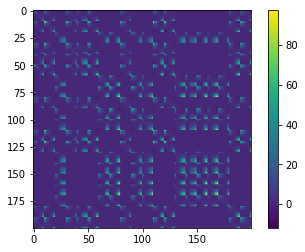

In [5]:
plt.imshow(k4(samp_df[["id", "treat", "time"]]))
plt.colorbar()

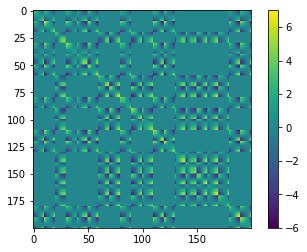

In [6]:
plt.imshow(k3(samp_df[["id", "treat", "time"]]))
plt.colorbar()

In [9]:
%%time
m3_search = full_kernel_search(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df.y4, # pd.DataFrame({"y4_scaled": y4_scaled}),
    kern_list=kernel_list,
    cat_vars=[0, 1],
    random_seed=9102,
    verbose=True,
    keep_only_best=True,
    max_depth=5
)

Working on depth 1 now
Pruning now
Best model for depth 1 is polynomial[2]
-----------

Working on depth 2 now
Pruning now
Current kernel component: categorical[1]*polynomial[2]
Currently dealing with product terms!
New best log likelihood: -492.35728835102003
New best log likelihood: -492.3572883496108
New best log likelihood: -492.35728834961054
Model: polynomial, BIC: 1000.61
Best model for depth 2 is categorical[1]*polynomial[2]
-----------

Working on depth 3 now
Pruning now
Current kernel component: categorical[0]
Current kernel component: categorical[1]*polynomial[2]
Currently dealing with product terms!
New best log likelihood: -541.9080541503067
New best log likelihood: -541.9080541502915
New best log likelihood: -541.908054150285
New best log likelihood: -541.9080541502786
New best log likelihood: -541.908054150272
Model: ['categorical', 'categorical'], BIC: 1094.41
Best model for depth 3 is categorical[0]+categorical[1]*polynomial[2]
-----------

Working on depth 4 now
Pruni

(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*squared_exponential[time] (47.1%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'categorical[treat]*polynomial[time] (51.6%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (1.3%)'}, xlabel='time'>],
       dtype=object))

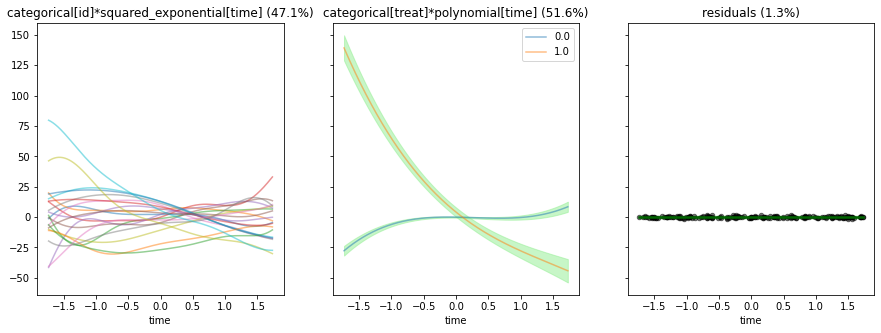

In [10]:
pred_kernel_parts(
    m=m3_search["models"][m3_search["best_model"]]["model"],
    k_names=m3_search["best_model"],
    time_idx=2,
    unit_idx=0,
    col_names=["id", "treat", "time"]
)

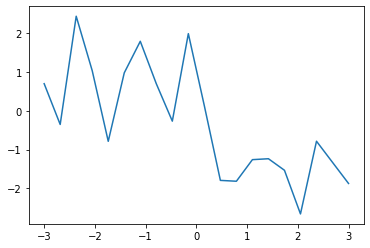

In [9]:
# Simulate some data
np.random.seed(901)
N = 20
X = np.array(np.linspace(start=-3, stop=3, num=N)).reshape(-1, 1)
k = gpflow.kernels.SquaredExponential() + Lin(active_dims=[0])
Y = np.random.multivariate_normal(
    mean=np.zeros_like(X).flatten(),
    cov=k(X) + 0.5 * np.eye(N),
    size=1
)[0].reshape(-1, 1)

plt.plot(X[:,0], Y)

In [10]:
# Now recover the kernel
m_test = kernel_test(
    X=X,
    Y=Y,
    k=k
)

m_test

(<gpflow.models.gpr.GPR object at 0x28dad9fa0>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 0.202917 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 1.01767  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │ Uniform 

<AxesSubplot:xlabel='time'>

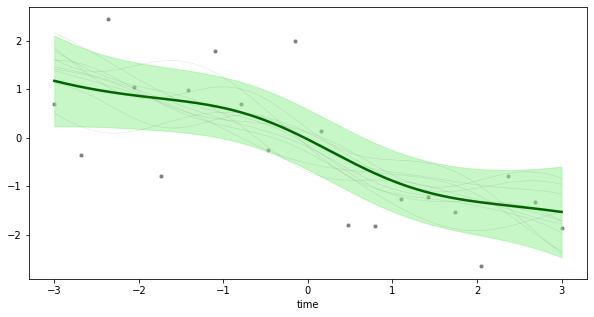

In [11]:
gp_predict_fun(
    gp=m_test[0],
    x_idx=0,
    unit_idx=None,
col_names=["time"])

(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'squared_exponential[time] (24.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'lin[time] (32.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (44.0%)'}, xlabel='time'>],
       dtype=object))

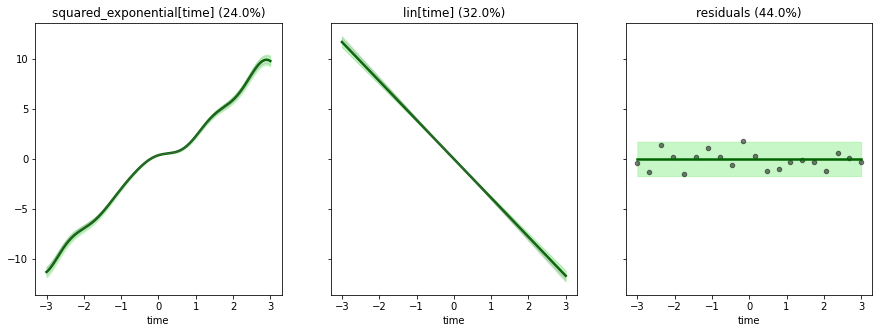

In [12]:
pred_kernel_parts(
    m=m_test[0],
    k_names='squared_exponential[0]+lin[0]',
    time_idx=0,
    unit_idx=None,
    col_names=["time"]
)

In [5]:
# Set up kernel list
kernel_list = [
        gpflow.kernels.SquaredExponential(),
        gpflow.kernels.Matern12(),
        gpflow.kernels.Linear(),
        gpflow.kernels.Polynomial(),
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
    ]

# Sample 5 observations per person
idx5 = samp_df.groupby("id").sample(n=5).index

# Take 5% of the data
# idx5 = samp_df.sample(frac=0.05).index

# Set up search object
gp5 = GPKernelSearch(
    X=samp_df.filter(idx5, axis=0)[["id", "treat", "time"]],
    Y=samp_df.filter(idx5, axis=0)[["y1", "y2", "y3", "y4"]],
    unit_col="id",
    categorical_vars=["id", "treat"]
)

# Now perform search
gp5.run_search(
    kernels=kernel_list,
    random_seed=9102,
    metric_diff=6
)

Kernel search: 100%|█████████████████████████████████████████████████████████████████| 4/4 [01:52<00:00, 28.22s/it]


In [6]:
y4_full = full_kernel_search(
    X=samp_df.filter(idx5, axis=0)[["id", "treat", "time"]],
    Y=samp_df.filter(idx5, axis=0)[["y4"]],
    cat_vars=[0, 1],
    keep_all=True,
    early_stopping=False,
    prune=False,
    keep_only_best=False,
    random_seed=9102,
    verbose=True,
    kern_list=kernel_list
)

Working on depth 1 now
Best model for depth 1 is categorical[0]
-----------

Working on depth 2 now
Best model for depth 2 is categorical[1]*polynomial[2]
-----------

Working on depth 3 now
Best model for depth 3 is categorical[0]+categorical[1]*polynomial[2]
-----------

Working on depth 4 now
Best model for depth 4 is categorical[0]*matern12[2]+categorical[1]*polynomial[2]
-----------

Working on depth 5 now
Best model for depth 5 is categorical[0]*matern12[2]+categorical[1]*polynomial[2]
Reached max depth, ending search.
Best model for depth 5 is categorical[0]*matern12[2]+categorical[1]*polynomial[2]


In [90]:
mu_hat, var_hat = foo_best[0].predict_y(foo_best[0].data[0])

In [94]:
# Calculate R-squared (1-SSR/SST)
1-np.sum((foo_best[0].data[1]-mu_hat)**2)/np.sum((foo_best[0].data[1]-0)**2)

0.9914076122982812

In [88]:
np.mean(samp_df.y4)

-2.5787668050586925

(array([ 11.,  30.,  35.,  71., 107., 266., 807., 597.,  60.,  16.]),
 array([-23.33910053, -20.07129632, -16.80349212, -13.53568791,
        -10.2678837 ,  -7.00007949,  -3.73227529,  -0.46447108,
          2.80333313,   6.07113734,   9.33894154]),
 <BarContainer object of 10 artists>)

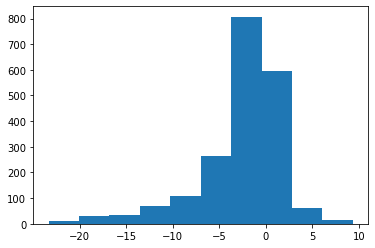

In [86]:
plt.hist(samp_df.y4)

In [87]:
foo_best = kernel_test(
    X=samp_df[["id", "treat", "time"]],
    Y=samp_df[["y4"]],
    k=(Categorical(active_dims=[0]) +
          Categorical(active_dims=[1]) *
          gpflow.kernels.Polynomial(active_dims=[2]) +
          Categorical(active_dims=[0]) *
          gpflow.kernels.SquaredExponential(active_dims=[2]))
)

In [14]:
foo_best

(<gpflow.models.gpr.GPR object at 0x339948b50>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.543    │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.467385 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│

In [96]:
[x/sum(variance_contributions_diag(foo_best[0])) for x in variance_contributions_diag(foo_best[0])]

[6.220366814850912e-13,
 0.9999999999958052,
 2.7930532330298634e-12,
 7.796882076825884e-13]

In [15]:
sorted([(k, v["bic"]) for k, v in y4_full["models"].items()], key = lambda x: x[1])[:5]

[('categorical[0]*matern12[2]+categorical[1]*polynomial[2]', 810.4),
 ('categorical[0]*squared_exponential[2]+categorical[1]*polynomial[2]',
  811.25),
 ('categorical[0]*matern12[2]+categorical[1]*polynomial[2]+linear[2]', 815.92),
 ('categorical[0]*matern12[2]+categorical[1]+categorical[1]*polynomial[2]',
  816.21),
 ('categorical[0]*squared_exponential[2]+categorical[1]*polynomial[2]+linear[2]',
  816.77)]

In [ ]:
# Sample 25 observations per person
idx25 = samp_df.groupby("id").sample(n=25).index

# Take 25% of the data
# idx25 = samp_df.sample(frac=0.25).index

# Set up search object
gp25 = GPKernelSearch(
    X=samp_df.filter(idx25, axis=0)[["id", "treat", "time"]],
    Y=samp_df.filter(idx25, axis=0)[["y1", "y2", "y3", "y4"]],
    unit_col="id",
    categorical_vars=["id", "treat"]
)

# Now perform search
gp25.run_search(
    kernels=kernel_list,
    random_seed=9102,
    metric_diff=6
)

In [45]:
# # Sample 50 observations per person
idx50 = samp_df.groupby("id").sample(n=50).index

# Take 50% of the data
# idx50 = samp_df.sample(frac=0.50).index

# Set up search object
gp50 = GPKernelSearch(
    X=samp_df.filter(idx50, axis=0)[["id", "treat", "time"]],
    Y=samp_df.filter(idx50, axis=0)[["y1", "y2", "y3", "y4"]],
    unit_col="id",
    categorical_vars=["id", "treat"]
)

# Now perform search
gp50.run_search(
    kernels=kernel_list,
    random_seed=9102,
    metric_diff=6
)

Kernel search: 100%|████████████████████████████████| 4/4 [5:02:34<00:00, 4538.72s/it]


In [46]:
# Sample 100 observations per person
idx100 = samp_df.groupby("id").sample(n=100).index

# Take the entire dataset now

# Set up search object
gp100 = GPKernelSearch(
    X=samp_df.filter(idx100, axis=0)[["id", "treat", "time"]],
    Y=samp_df.filter(idx100, axis=0)[["y1", "y2", "y3", "y4"]],
    unit_col="id",
    categorical_vars=["id", "treat"]
)

# Now perform search
gp100.run_search(
    kernels=kernel_list,
    random_seed=9102,
    metric_diff=6
)

Kernel search: 100%|██████████████████████████████| 4/4 [25:16:53<00:00, 22753.28s/it]


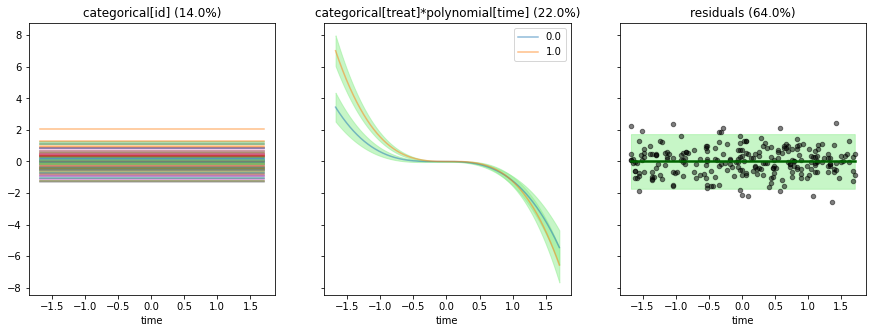

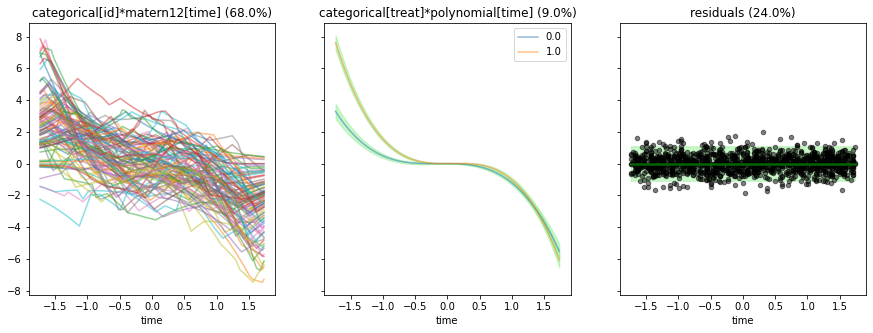

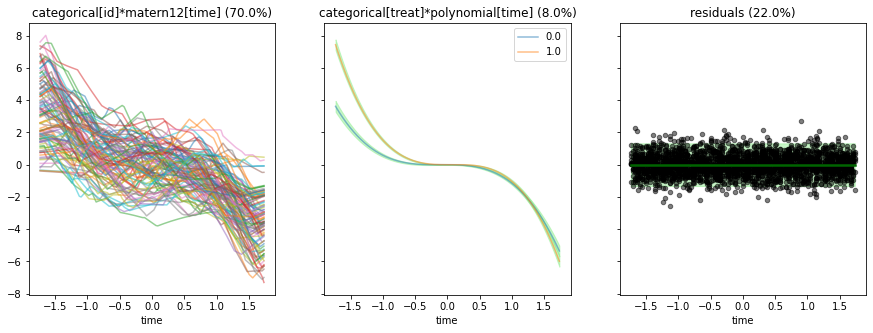

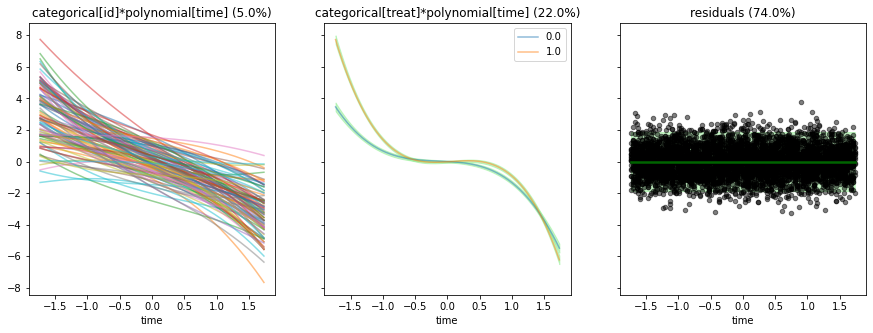

In [47]:
# Using metric_diff=6
gp5.plot_parts(out_label="y4", x_axis_label="time");
gp25.plot_parts(out_label="y4", x_axis_label="time");
gp50.plot_parts(out_label="y4", x_axis_label="time");
gp100.plot_parts(out_label="y4", x_axis_label="time");

In [201]:
250/0.05

5000.0

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWar

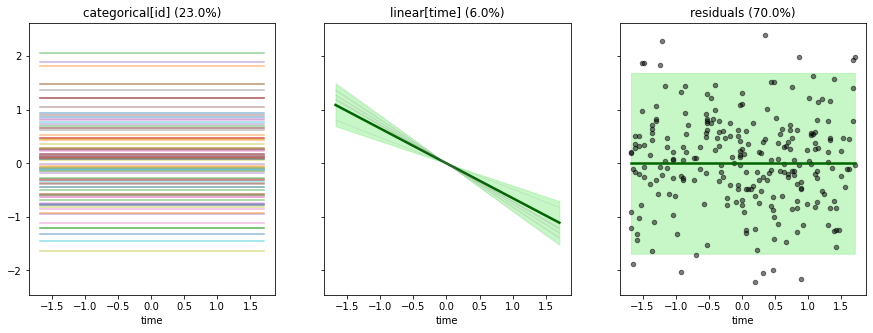

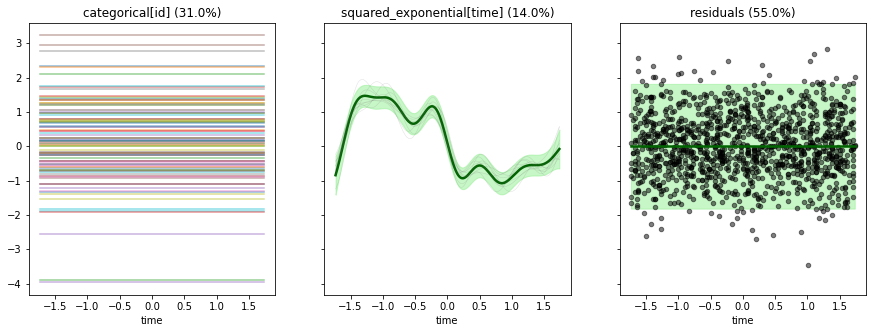

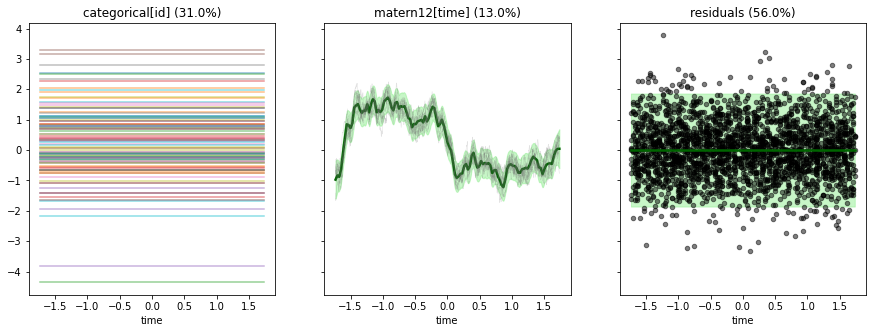

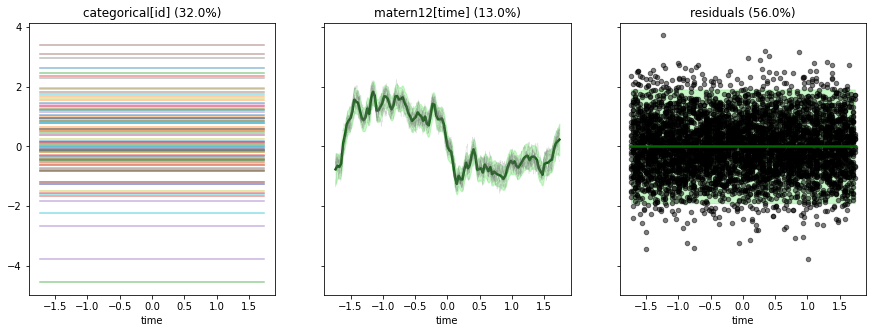

In [48]:
# Using metric_diff=6
gp5.plot_parts(out_label="y1", x_axis_label="time");
gp25.plot_parts(out_label="y1", x_axis_label="time");
gp50.plot_parts(out_label="y1", x_axis_label="time");
gp100.plot_parts(out_label="y1", x_axis_label="time");

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWar

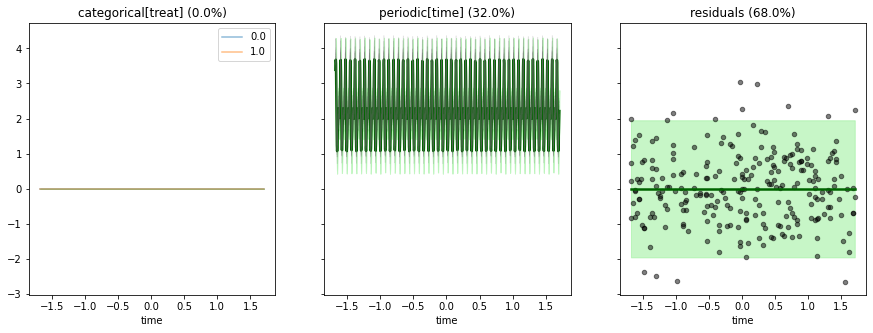

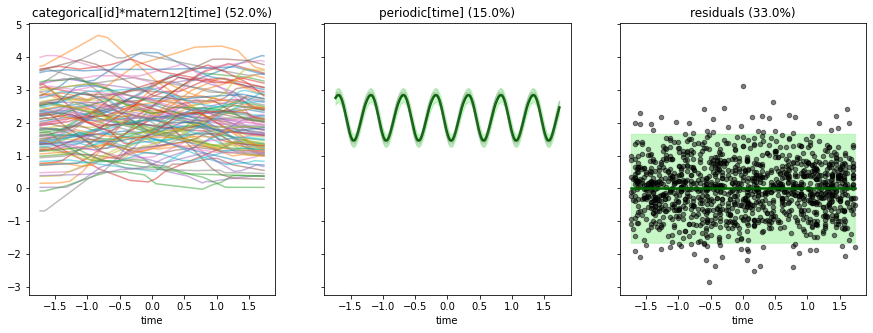

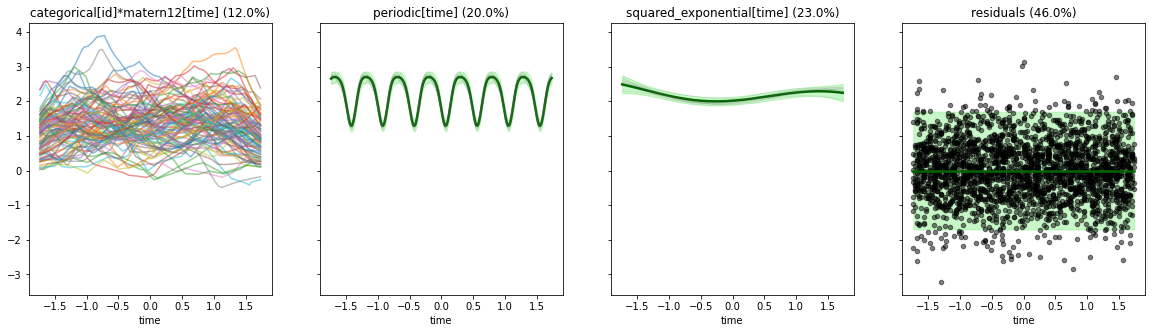

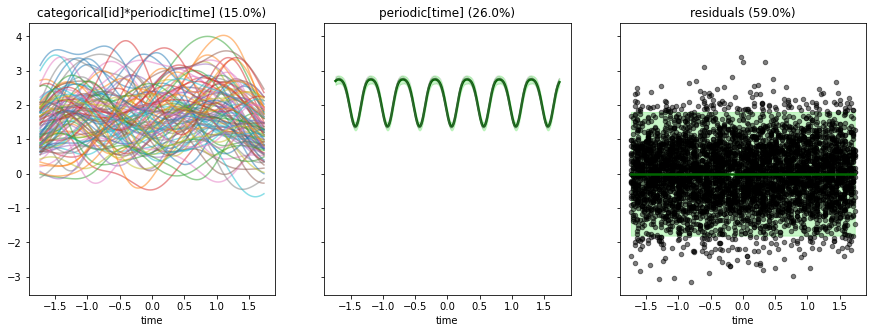

In [56]:
# Using metric_diff=6
gp5.plot_parts(out_label="y2", x_axis_label="time");
gp25.plot_parts(out_label="y2", x_axis_label="time");
gp50.plot_parts(out_label="y2", x_axis_label="time");
gp100.plot_parts(out_label="y2", x_axis_label="time");

In [53]:
gp100.models["y4"]["models"]['categorical[0]*polynomial[2]+categorical[1]*polynomial[2]']["model"].log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-10306.639383027912>

In [55]:
gp100.models["y4"]["models"]['categorical[0]*polynomial[2]+categorical[1]*polynomial[2]']["bic"]

20666.6

In [50]:
# How different is this from the best model?

foo = gpflow.models.GPR(
    data=(samp_df[["id", "treat", "time"]].to_numpy().reshape(-1, 3),
          samp_df[["y4"]].to_numpy().reshape(-1, 1)),
    kernel=(Categorical(active_dims=[0], variance=0.5) +
          Categorical(active_dims=[1], variance=1.5) *
          gpflow.kernels.Polynomial(degree=3,
                                    offset=0.1,
                                    variance=1.0,
                                    active_dims=[2]) +
          Categorical(active_dims=[0], variance=1.0) *
          gpflow.kernels.SquaredExponential(variance=1.0,
                                            lengthscales=0.5,
                                            active_dims=[2])),
    noise_variance=3.0
)

foo.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-10217.026068347159>

In [54]:
calc_bic(foo.log_marginal_likelihood(), samp_df.shape[0], len(foo.parameters))

<tf.Tensor: shape=(), dtype=float64, numpy=20502.189682225646>

In [ ]:
pred_kernel_part

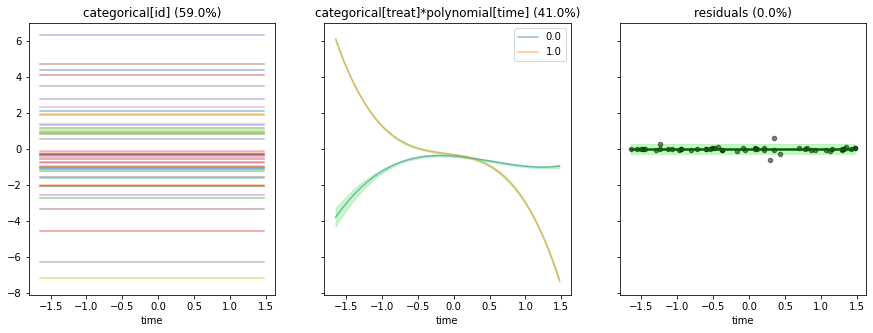

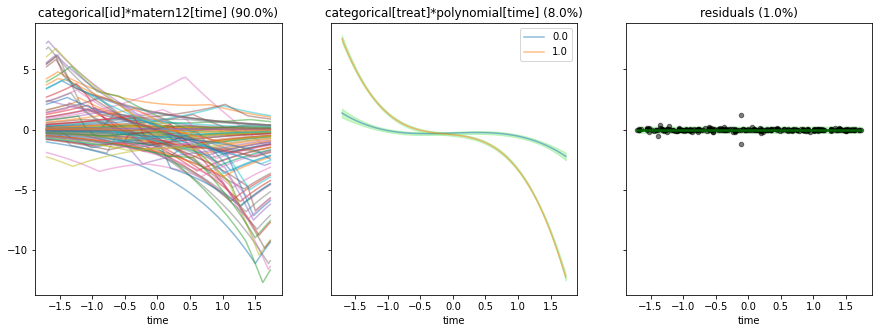

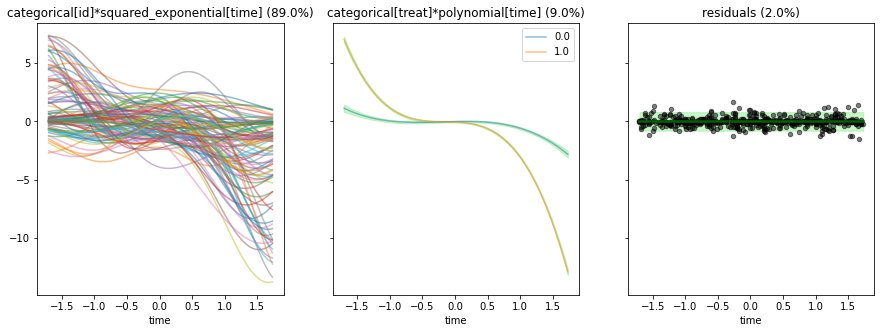

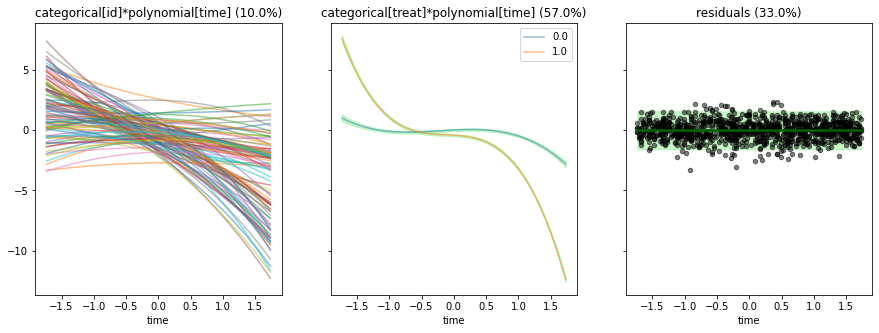

In [29]:
# Using metric_diff=2
gp5.plot_parts(out_label="y4", x_axis_label="time");
gp25.plot_parts(out_label="y4", x_axis_label="time");
gp50.plot_parts(out_label="y4", x_axis_label="time");
gp100.plot_parts(out_label="y4", x_axis_label="time");

Can we calculate the Bhattacharyya distance for the recovered distribution compared to the original?

In [7]:
from scipy.stats import multivariate_normal

multivariate_normal.pdf([0, 0], mean=[0, 0], cov=np.array([[1, 0], [0, 1]]))

0.15915494309189535

In [22]:
p_prob = multivariate_normal.pdf(
    samp_df.filter(idx5, axis=0)[["y1"]],
    mean=np.zeros(len(idx5)),
    cov=k1.K(samp_df.filter(idx5, axis=0)[["id", "treat", "time"]].to_numpy().reshape(-1, 3))
)

In [23]:
q_prob = multivariate_normal.pdf(
    samp_df.filter(idx5, axis=0)[["y1"]],
    mean=np.zeros(len(idx5)),
    cov=(gp5.models["y1"]["models"][gp5.models["y1"]["best_model"]]["model"].
         kernel.K(
             samp_df.filter(idx5, axis=0)[["id", "treat", "time"]].to_numpy().reshape(-1, 3)
         )
        ) + 1e-6 * np.eye(len(idx5))
)

In [25]:
# Bhattacharyya distance
-np.log(np.sum(np.sqrt(p_prob*q_prob)))

54.31813247707453

In [8]:
# samp_df.to_csv('simulated_data_full.csv', index=False)

In [9]:
# samp_df.head()

## Simulation

Run simulation_test.py

In [42]:
sim_results = []

for infile in glob.glob("sim_results_part*"):
    print(infile)
    
    # Get the simulation suffix number
    file_iter = int(re.search("part(.+?).pkl", infile).group(1))
    
    # Skip iteration 5 for the moment
    if file_iter == 5:
        continue
    
    # Open and read file
    next_run = pickle.load(open(infile, "rb"))
    
    # Update iteration count in set appropriately
    next_run["iter"] = file_iter * next_run["iter"]
    
    # Add file to list
    sim_results.append(next_run)
    
# Now turn the list into one full dataframe
sim_results = pd.concat(sim_results)

sim_results_part9.pkl
sim_results_part8.pkl
sim_results_part5.pkl
sim_results_part4.pkl
sim_results_part6.pkl
sim_results_part7.pkl
sim_results_part3.pkl
sim_results_part2.pkl
sim_results_part1.pkl
sim_results_part10.pkl


In [6]:
#sim_results = pickle.load(open( "sim_results_new.pkl", "rb" ))

In [43]:
sim_results.iter.unique()

array([18, 27, 81,  0, 45, 63, 72,  9, 36, 54,  8, 24, 40, 32, 56, 48, 16,
       64, 20, 12, 28,  4,  6, 42, 30, 14,  7, 35, 49, 21, 15,  3, 10,  2,
        1,  5, 80, 50, 60, 70, 90])

In [44]:
sim_results

rate  eps  units  iter output  \
0     16  0.0     40    18     y1   
1     16  0.0     40    18     y2   
2     16  0.0     40    18     y3   
3     16  0.0     40    18     y4   
0      4  0.0     80    18     y1   
..   ...  ...    ...   ...    ...   
3     16  3.0     80    30     y4   
0      8  0.0     60    30     y1   
1      8  0.0     60    30     y2   
2      8  0.0     60    30     y3   
3      8  0.0     60    30     y4   

                                               kernel  \
0                          categorical[0]+matern12[2]   
1                                         periodic[2]   
2   categorical[0]*squared_exponential[2]+categori...   
3   categorical[0]*polynomial[2]+categorical[1]*po...   
0                          categorical[0]+matern12[2]   
..                                                ...   
3   categorical[0]*matern12[2]+categorical[1]*poly...   
0                          categorical[0]+matern12[2]   
1              categorical[0]*periodic[2]+periodic[2]   
2   categorical[0]*squared_exponential[2]+categori...   
3   categorical[0]*polynomial[2]+categorical[1]*po...   

                                                model  
0   {'kernel': <gpflow.kernels.base.Sum object at ...  
1   {'kernel': <gpflow.kernels.periodic.Periodic o...  
2   {'kernel': <gpflow.kernels.base.Sum object at ...  
3   {'kernel': <gpflow.kernels.base.Sum object at ...  
0   {'kernel': <gpflow.kernels.base.Sum object at ...  
..                                                ...  
3   {'kernel': <gpflow.kernels.base.Sum object at ...  
0   {'kernel': <gpflow.kernels.base.Sum object at ...  
1   {'kernel': <gpflow.kernels.base.Sum object at ...  
2   {'kernel': <gpflow.kernels.base.Sum object at ...  
3   {'kernel': <gpflow.kernels.base.Sum object at ...  

[23040 rows x 7 columns]

In [45]:
sim_results.query("output == 'y4'").kernel.value_counts()

categorical[0]*polynomial[2]+categorical[1]*polynomial[2]              928
categorical[0]*polynomial[2]                                           876
categorical[0]*squared_exponential[2]+categorical[1]*polynomial[2]     666
constant                                                               644
categorical[1]*polynomial[2]                                           545
                                                                      ... 
categorical[1]+lin[2]                                                    1
categorical[0]*lin[2]+polynomial[2]                                      1
categorical[0]*categorical[1]+categorical[0]*squared_exponential[2]      1
categorical[0]*polynomial[2]+categorical[0]*periodic[2]                  1
categorical[0]*periodic[2]+lin[2]                                        1
Name: kernel, Length: 79, dtype: int64

In [46]:
sim_results.query("output == 'y3'").head()

rate   eps  units  iter output  \
2    16   0.0     40    18     y3   
2     4   0.0     80    18     y3   
2     4   0.3     80    27     y3   
2    32  30.0     60    81     y3   
2     8   3.0     60    27     y3   

                                              kernel  \
2  categorical[0]*squared_exponential[2]+categori...   
2                       categorical[0]*polynomial[2]   
2                       categorical[0]*polynomial[2]   
2               categorical[0]+categorical[1]*lin[2]   
2                              categorical[0]+lin[2]   

                                               model  
2  {'kernel': <gpflow.kernels.base.Sum object at ...  
2  {'kernel': <gpflow.kernels.base.Product object...  
2  {'kernel': <gpflow.kernels.base.Product object...  
2  {'kernel': <gpflow.kernels.base.Sum object at ...  
2  {'kernel': <gpflow.kernels.base.Sum object at ...

In [49]:
sim_results.query("output == 'y3' and eps == 0.0").kernel.value_counts()

categorical[0]*polynomial[2]+categorical[1]*lin[2]                           493
categorical[0]*squared_exponential[2]+categorical[1]*lin[2]                  423
categorical[0]*polynomial[2]                                                 179
categorical[0]*squared_exponential[2]                                        121
categorical[0]+categorical[1]*lin[2]                                          87
categorical[0]*squared_exponential[2]+categorical[1]*lin[2]+lin[2]            84
categorical[0]*polynomial[2]+lin[2]                                           12
categorical[0]*squared_exponential[2]+lin[2]                                   9
categorical[0]*squared_exponential[2]+categorical[1]*polynomial[2]+lin[2]      8
categorical[0]*squared_exponential[2]+categorical[1]*polynomial[2]             7
categorical[0]*polynomial[2]+categorical[1]*lin[2]+lin[2]                      6
categorical[0]+categorical[1]*lin[2]+lin[2]                                    4
categorical[0]*lin[2]+catego

In [55]:
sim_results.query("output == 'y3' and eps == 0.0 and iter == 0")

rate  eps  units  iter output  \
11551    32  0.0     40     0     y3   
11561    32  0.0     60     0     y3   
11649    32  0.0     20     0     y3   
11728     4  0.0     80     0     y3   
11795     4  0.0     60     0     y3   
...     ...  ...    ...   ...    ...   
17180    16  0.0     20     0     y3   
17222    16  0.0     60     0     y3   
17243    32  0.0     40     0     y3   
17246     4  0.0     40     0     y3   
17269    32  0.0     20     0     y3   

                                                  kernel  \
11551  categorical[0]*squared_exponential[2]+categori...   
11561  categorical[0]*squared_exponential[2]+categori...   
11649                       categorical[0]*polynomial[2]   
11728              categorical[0]*squared_exponential[2]   
11795                       categorical[0]*polynomial[2]   
...                                                  ...   
17180              categorical[0]*squared_exponential[2]   
17222  categorical[0]*squared_exponential[2]+categori...   
17243                       categorical[0]*polynomial[2]   
17246  categorical[0]*polynomial[2]+categorical[1]*li...   
17269                       categorical[0]*polynomial[2]   

                                                   model  \
11551  {'kernel': <gpflow.kernels.base.Sum object at ...   
11561  {'kernel': <gpflow.kernels.base.Sum object at ...   
11649  {'kernel': <gpflow.kernels.base.Product object...   
11728  {'kernel': <gpflow.kernels.base.Product object...   
11795  {'kernel': <gpflow.kernels.base.Product object...   
...                                                  ...   
17180  {'kernel': <gpflow.kernels.base.Product object...   
17222  {'kernel': <gpflow.kernels.base.Sum object at ...   
17243  {'kernel': <gpflow.kernels.base.Product object...   
17246  {'kernel': <gpflow.kernels.base.Sum object at ...   
17269  {'kernel': <gpflow.kernels.base.Product object...   

                                true_kernel  
11551  categorical[0]+categorical[1]*lin[2]  
11561  categorical[0]+categorical[1]*lin[2]  
11649  categorical[0]+categorical[1]*lin[2]  
11728  categorical[0]+categorical[1]*lin[2]  
11795  categorical[0]+categorical[1]*lin[2]  
...                                     ...  
17180  categorical[0]+categorical[1]*lin[2]  
17222  categorical[0]+categorical[1]*lin[2]  
17243  categorical[0]+categorical[1]*lin[2]  
17246  categorical[0]+categorical[1]*lin[2]  
17269  categorical[0]+categorical[1]*lin[2]  

[144 rows x 8 columns]

(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*squared_exponential[time] (98.2%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'categorical[treat]*lin[time] (1.8%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='time'>],
       dtype=object))

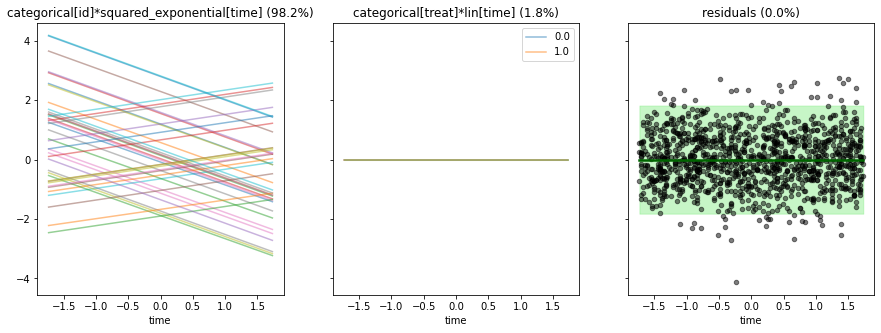

In [58]:
pred_kernel_parts(
    m=sim_results.query("output == 'y3' and eps == 0.0 and iter == 0").model.iloc[0]["model"],
    k_names=sim_results.query("output == 'y3' and eps == 0.0 and iter == 0").kernel.iloc[0],
    time_idx=2,
    unit_idx=0,
    col_names=["id", "treat", "time"]
)

In [65]:
foo_dict = {"categorical[0]*squared_exponential[2]+categorical[1]*lin[2]": 
            sim_results.query("output == 'y3' and eps == 0.0 and iter == 0").model.iloc[0]}

pruned_foo = prune_best_model2(
    res_dict=foo_dict,
    depth=4,
    lik="gaussian"
)

Found better kernel! categorical[0]+categorical[1]*lin[2]


/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<AxesSubplot:xlabel='time'>

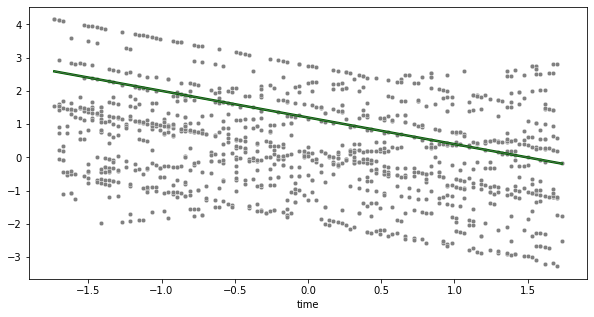

In [68]:
gp_predict_fun(
    gp=pruned_foo["categorical[0]+categorical[1]*lin[2]"]["model"],
    x_idx=2,
    unit_idx=0,
    col_names=["id", "treat", "time"]
)

In [72]:
np.argwhere([x == "categorical[1]*lin[2]" for x in ["categorical[0]", "categorical[1]*lin[2]"]])[0][0]

1

In [73]:
pruned_foo["categorical[0]+categorical[1]*lin[2]"]["model"].kernel.kernels[1]

<gpflow.kernels.base.Product object at 0x4c4387df0>
╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ Product.kernels[0].variance │ Parameter │ Softplus    │ Uniform │ False       │ ()      │ float64 │ 1        │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ Product.kernels[1].variance │ Parameter │ Softplus    │ Uniform │ True        │ ()      │ float64 │ 0.376022 │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧══════════╛

In [83]:
test_kernel = (Categorical(active_dims=[1], variance=1.0) * 
               gpflow.kernels.Linear(active_dims=[2], variance=0.376022))
test_kernel.K(
    np.array([np.repeat(10, 5), np.repeat(0, 5),np.linspace(-3,3,5)]).T.reshape(-1, 3)
)

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[40.986398 , 39.294299 , 37.6022   , 35.910101 , 34.218002 ],
       [39.294299 , 38.4482495, 37.6022   , 36.7561505, 35.910101 ],
       [37.6022   , 37.6022   , 37.6022   , 37.6022   , 37.6022   ],
       [35.910101 , 36.7561505, 37.6022   , 38.4482495, 39.294299 ],
       [34.218002 , 35.910101 , 37.6022   , 39.294299 , 40.986398 ]])>

In [89]:
test_kernel2 = (Categorical(active_dims=[1], variance=1.0) * 
               Lin(active_dims=[2], variance=0.376022))
test_kernel2.K(
    np.array([np.repeat(10, 5), np.repeat(0, 5),np.linspace(-3,3,5)]).T.reshape(-1, 3)
)

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[ 3.384198 ,  1.692099 , -0.       , -1.692099 , -3.384198 ],
       [ 1.692099 ,  0.8460495, -0.       , -0.8460495, -1.692099 ],
       [-0.       , -0.       ,  0.       ,  0.       ,  0.       ],
       [-1.692099 , -0.8460495,  0.       ,  0.8460495,  1.692099 ],
       [-3.384198 , -1.692099 ,  0.       ,  1.692099 ,  3.384198 ]])>

In [94]:
pruned_foo["categorical[0]+categorical[1]*lin[2]"]["model"]

<gpflow.models.gpr.GPR object at 0x4c437c1f0>
╒═══════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance            │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 1.6846      │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].kernels[0].variance │ Parameter │ Softplus         │ Uniform │ False       │ ()      │ float64 │ 1           │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].kernels[1].variance │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 0.376022    │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance                   │ Parameter │ Softplus + Shift │ Uniform │ True        │ ()      │ float64 │ 1.00001e-06 │
╘═══════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════╛

In [100]:
pruned_foo["categorical[0]+categorical[1]*lin[2]"]["model"].kernel.kernels[1].kernels[1].K(
    np.array([np.array([1,1,1,2,2]), np.array([0,0,1,1,1]) , np.linspace(-3,3,5)]).T.reshape(-1, 3)
)

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[0.37602245, 0.37602245, 0.37602245, 0.7520449 , 0.7520449 ],
       [0.37602245, 0.37602245, 0.37602245, 0.7520449 , 0.7520449 ],
       [0.37602245, 0.37602245, 0.37602245, 0.7520449 , 0.7520449 ],
       [0.7520449 , 0.7520449 , 0.7520449 , 1.50408981, 1.50408981],
       [0.7520449 , 0.7520449 , 0.7520449 , 1.50408981, 1.50408981]])>

In [76]:
mu_, var_, samps_, cov_ = individual_kernel_predictions(
    model=pruned_foo["categorical[0]+categorical[1]*lin[2]"]["model"],
    kernel_idx=1,
    X=np.array([np.repeat(10, 5), np.repeat(0, 5),np.linspace(-3,3,5)]).T.reshape(-1, 3)
)

In [79]:
cov_

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[0.01942418, 0.01937418, 0.01937418, 0.01937418, 0.01937674],
       [0.01937418, 0.01942418, 0.01937418, 0.01937418, 0.01937674],
       [0.01937418, 0.01937418, 0.01942418, 0.01937418, 0.01937674],
       [0.01937418, 0.01937418, 0.01937418, 0.01942418, 0.01937674],
       [0.01937418, 0.01937418, 0.01937418, 0.01937418, 0.01942674]])>

k_name=categorical[0]
k_name=categorical[1]*lin[2]


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id] (82.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'categorical[treat]*lin[time] (18.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='time'>],
       dtype=object))

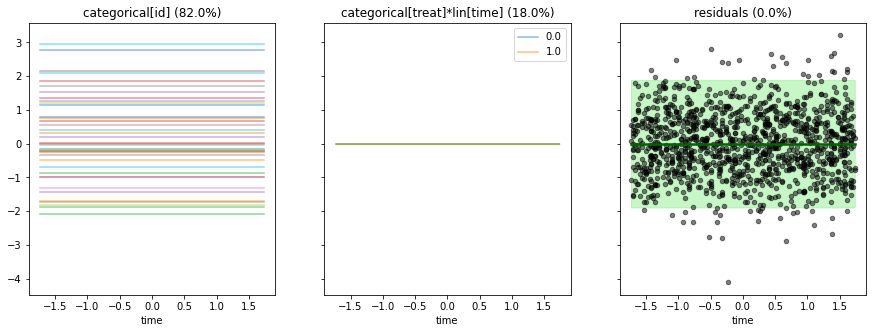

In [70]:
pred_kernel_parts(
    m=pruned_foo["categorical[0]+categorical[1]*lin[2]"]["model"],
    k_names="categorical[0]+categorical[1]*lin[2]",
    time_idx=2,
    unit_idx=0,
    col_names=["id", "treat", "time"]
)

In [102]:
sim_results.query("output == 'y3' and eps == 0.0 and iter == 0").model.iloc[0]["model"].data[0]

<tf.Tensor: shape=(1206, 3), dtype=float64, numpy=
array([[ 0.        ,  0.        , -1.47224319],
       [ 0.        ,  0.        , -1.44337567],
       [ 0.        ,  0.        , -1.35677313],
       ...,
       [39.        ,  0.        ,  1.41450816],
       [39.        ,  0.        ,  1.47224319],
       [39.        ,  0.        ,  1.67431578]])>

In [106]:
%%time
# Try to rerun the search with the new functions
y3_test_search = full_kernel_search(
    X=pd.DataFrame(sim_results.query("output == 'y3' and eps == 0.0 and iter == 0").model.iloc[0]["model"].data[0].numpy()),
    Y=pd.DataFrame(sim_results.query("output == 'y3' and eps == 0.0 and iter == 0").model.iloc[0]["model"].data[1].numpy()),
    kern_list=[
        Lin(),
        gpflow.kernels.SquaredExponential(),
        gpflow.kernels.Matern12(),
        gpflow.kernels.Polynomial(),
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
    ],
    cat_vars=[0,1],
    random_seed=9102,
    verbose=True
)

Working on depth 1 now
Pruning now
Best model for depth 1 is categorical[0]
-----------

Working on depth 2 now
Pruning now
Current kernel component: categorical[0]*squared_exponential[2]
Currently dealing with product terms!
New best log likelihood: -2128.886928215713
Model: squared_exponential, BIC: 4271.96
Best model for depth 2 is categorical[0]*squared_exponential[2]
-----------

Working on depth 3 now
Pruning now
Current kernel component: categorical[0]*squared_exponential[2]
Currently dealing with product terms!
New best log likelihood: -2132.93639112373
New best log likelihood: -2132.93637632816
New best log likelihood: -2132.936376254065
New best log likelihood: -2132.9363761828454
New best log likelihood: -2132.936376114393
Model: ['lin', 'squared_exponential'], BIC: 4287.16
Current kernel component: lin[2]
Best model for depth 3 is categorical[0]*squared_exponential[2]+lin[2]
-----------

Working on depth 4 now
Pruning now
Current kernel component: categorical[0]*squared_exp

In [113]:
y3_test_search["models"][y3_test_search["best_model"]]["model"]

<gpflow.models.gpr.GPR object at 0x53ab8cf10>
╒═══════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance            │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 1           │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].kernels[0].variance │ Parameter │ Softplus         │ Uniform │ False       │ ()      │ float64 │ 1           │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].kernels[1].variance │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 1           │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance                   │ Parameter │ Softplus + Shift │ Uniform │ True        │ ()      │ float64 │ 1.00001e-06 │
╘═══════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════╛

In [133]:
y3_test_search["models"][y3_test_search["best_model"]]["model"].kernel.kernels[1].kernels[1].active_dims[0]

2

In [161]:
X=sim_results.query("output == 'y3' and eps == 0.0 and iter == 0").model.iloc[0]["model"].data[0].numpy()
Y=sim_results.query("output == 'y3' and eps == 0.0 and iter == 0").model.iloc[0]["model"].data[1].numpy()
prune_best_model2(
    res_dict={"categorical[0]*periodic[2]+categorical[1]*linear[2]": {
                   
                   "model": gpflow.models.GPR(data=(X,Y),
                                         kernel=(#Categorical(active_dims=[0])*
                                                 gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(active_dims=[2])) + 
                                                 Categorical(active_dims=[1])*gpflow.kernels.Linear(active_dims=[2]))
                                        )
                  ,
                  "bic": 10000,
                  "depth": 1
                  }},
    depth=1,
    lik="gaussian",
    verbose=True
)

Current kernel component: categorical[0]*periodic[2]
Currently dealing with product terms!


AttributeError: 'Periodic' object has no attribute 'kernels'

In [130]:
X_test = np.array([np.array([1,1,1,2,2]), np.array([0,0,1,1,1]) , np.linspace(-3,3,5)]).T.reshape(-1, 3)
if X_test.shape[1] > 1:
    X_new = tf.cast(tf.reshape(X_test[:, 2], (-1, 1)), tf.float64)

In [132]:
Lin(active_dims=[2]).K(X_test)

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[ 9.  ,  4.5 , -0.  , -4.5 , -9.  ],
       [ 4.5 ,  2.25, -0.  , -2.25, -4.5 ],
       [-0.  , -0.  ,  0.  ,  0.  ,  0.  ],
       [-4.5 , -2.25,  0.  ,  2.25,  4.5 ],
       [-9.  , -4.5 ,  0.  ,  4.5 ,  9.  ]])>

In [119]:
y3_test_search["models"][y3_test_search["best_model"]]["model"].kernel.kernels[1].kernels[1].K(
    np.array([np.repeat(10, 5), np.repeat(0, 5),np.linspace(-3,3,5)]).T.reshape(-1, 3)
)

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100.]])>

k_name=categorical[0]
k_name=categorical[1]*lin[2]


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id] (82.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'categorical[treat]*lin[time] (18.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='time'>],
       dtype=object))

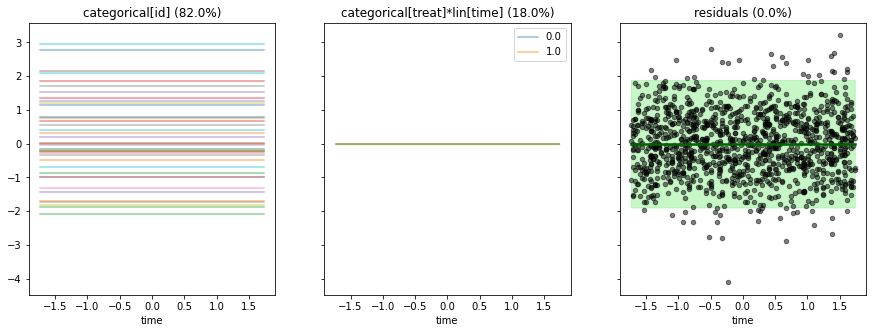

In [112]:
pred_kernel_parts(
    m=y3_test_search["models"][y3_test_search["best_model"]]["model"],
    k_names=y3_test_search["best_model"],
    time_idx=2,
    unit_idx=0,
    col_names=["id", "treat", "time"]
)

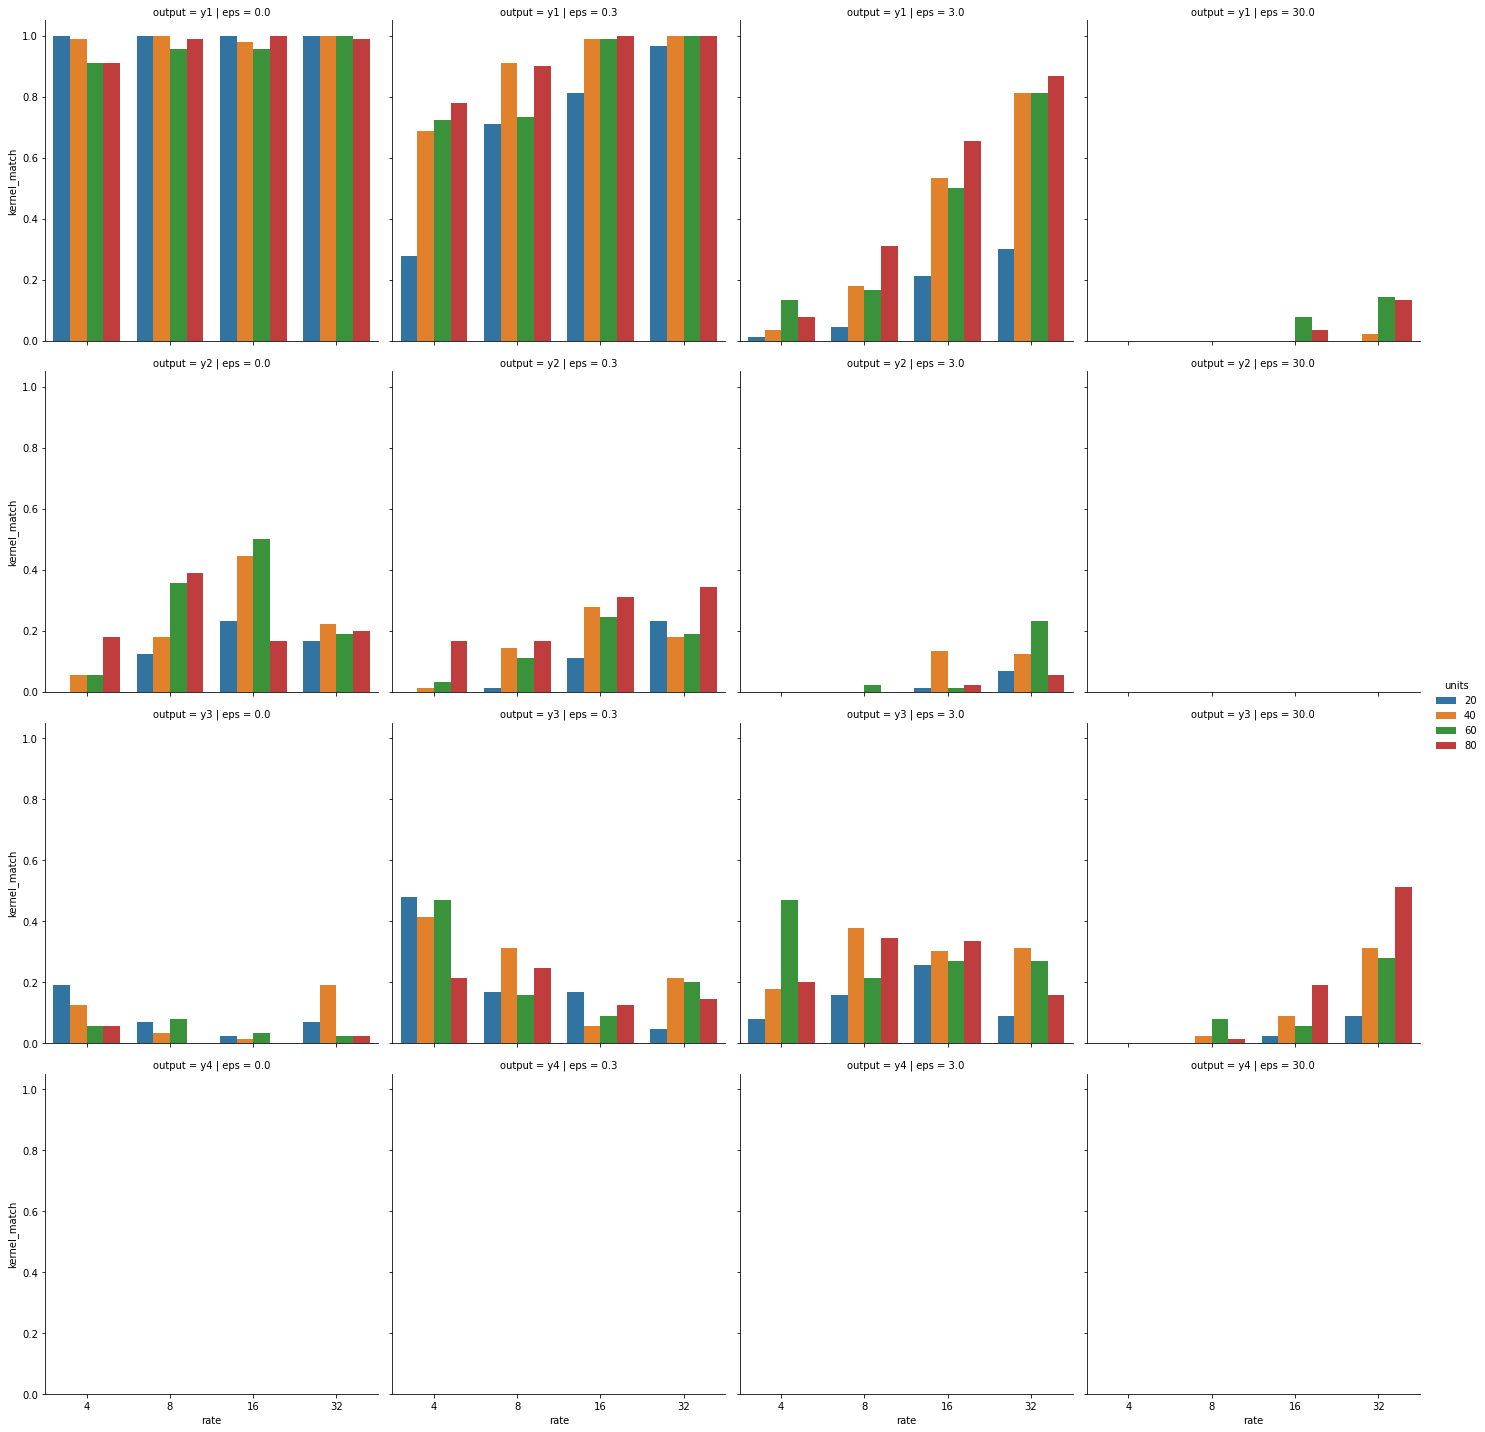

In [47]:
# Add a column for the true kernel
true_kernels = pd.DataFrame({
    'output': ['y1', 'y2', 'y3', 'y4'],
    'kernel': ['categorical[0]+matern12[2]',
        'categorical[0]*matern12[2]+periodic[2]',
        'categorical[0]+categorical[1]*lin[2]',
        'categorical[0]+categorical[0]*squared_exponential[2]+categorical[1]*polynomial[2]']
})


sim_results = (sim_results
 .merge(true_kernels.rename(columns={"kernel": "true_kernel"}))
 # .query("output == 'y4'")
 # .kernel
 # .value_counts()
)

# See how often the true kernel matches the recovered kernel
aggregate_mean_match = (sim_results
 .assign(kernel_match = sim_results.kernel == sim_results.true_kernel)
 .groupby(["rate", "eps", "units", "output"])
 .agg({"kernel_match": "mean"})
 .reset_index())

aggregate_mean_match
sns.catplot(
    data=aggregate_mean_match, #.query("output == 'y1'"),
    x='rate',
    # y='kernel_parts',
    y='kernel_match',
    col='eps', #'output',
    hue='units',
    row='output', #'output', #'eps',
    kind='bar',
    # row_order=['y1', 'y2', 'y3', 'y4'],
    # sharey=False
);

In [30]:
sim_results.head()

rate   eps  units  iter output                      kernel  \
0    16   0.0     40    18     y1  categorical[0]+matern12[2]   
1     4   0.0     80    18     y1  categorical[0]+matern12[2]   
2     4   0.3     80    27     y1  categorical[0]+matern12[2]   
3    32  30.0     60    81     y1              categorical[0]   
4     8   3.0     60    27     y1  categorical[0]+matern12[2]   

                                               model  \
0  {'kernel': <gpflow.kernels.base.Sum object at ...   
1  {'kernel': <gpflow.kernels.base.Sum object at ...   
2  {'kernel': <gpflow.kernels.base.Sum object at ...   
3  {'kernel': <helper_functions.Categorical objec...   
4  {'kernel': <gpflow.kernels.base.Sum object at ...   

                  true_kernel  
0  categorical[0]+matern12[2]  
1  categorical[0]+matern12[2]  
2  categorical[0]+matern12[2]  
3  categorical[0]+matern12[2]  
4  categorical[0]+matern12[2]

### How close is the distribution of estimated vs true?

In [47]:
mod_samp = sim_results[(sim_results.iter == 0) & (sim_results.output == "y1")]["model"].values[0]["model"]

In [63]:
mod_samp

<gpflow.models.gpr.GPR object at 0x41eff0b20>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 1.34954 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 1.06127 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │ Uniform │ True        │ ()      │ float64 │ 1.06449 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │ Uniform │ True        │ ()      │ float64 │ 3.02638 │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛

In [70]:
mod_samp.log_posterior_density()

<tf.Tensor: shape=(), dtype=float64, numpy=-1367.000547313241>

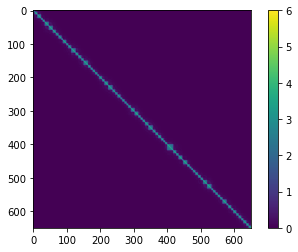

In [76]:
plt.imshow(k1.K(mod_samp.data[0]) + 3*np.eye(mod_samp.data[0].shape[0]))
plt.colorbar()

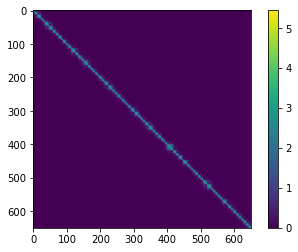

In [77]:
plt.imshow(mod_samp.kernel.K(mod_samp.data[0]) + 3.026*np.eye(mod_samp.data[0].shape[0]))
plt.colorbar()

In [79]:
from scipy.stats import multivariate_normal
original_loglik = multivariate_normal.logpdf(
    x=mod_samp.data[1],
    mean=np.zeros(shape=mod_samp.data[0].shape[0]),
    cov=k1.K(mod_samp.data[0]) + 3*np.eye(mod_samp.data[0].shape[0])
).sum()
print(f"True log likelihood = {original_loglik}")

estimated_loglik = multivariate_normal.logpdf(
    x=mod_samp.data[1],
    mean=np.zeros(shape=mod_samp.data[0].shape[0]),
    # cov=k1.K(mod_samp.data[0]) + 3*np.eye(mod_samp.data[0].shape[0])
    cov=mod_samp.kernel.K(mod_samp.data[0]) + 3.026*np.eye(mod_samp.data[0].shape[0])
).sum()
print(f"Estimated log likelihood = {estimated_loglik}")

True log likelihood = -740208.8391926154
Estimated log likelihood = -730727.2002923973


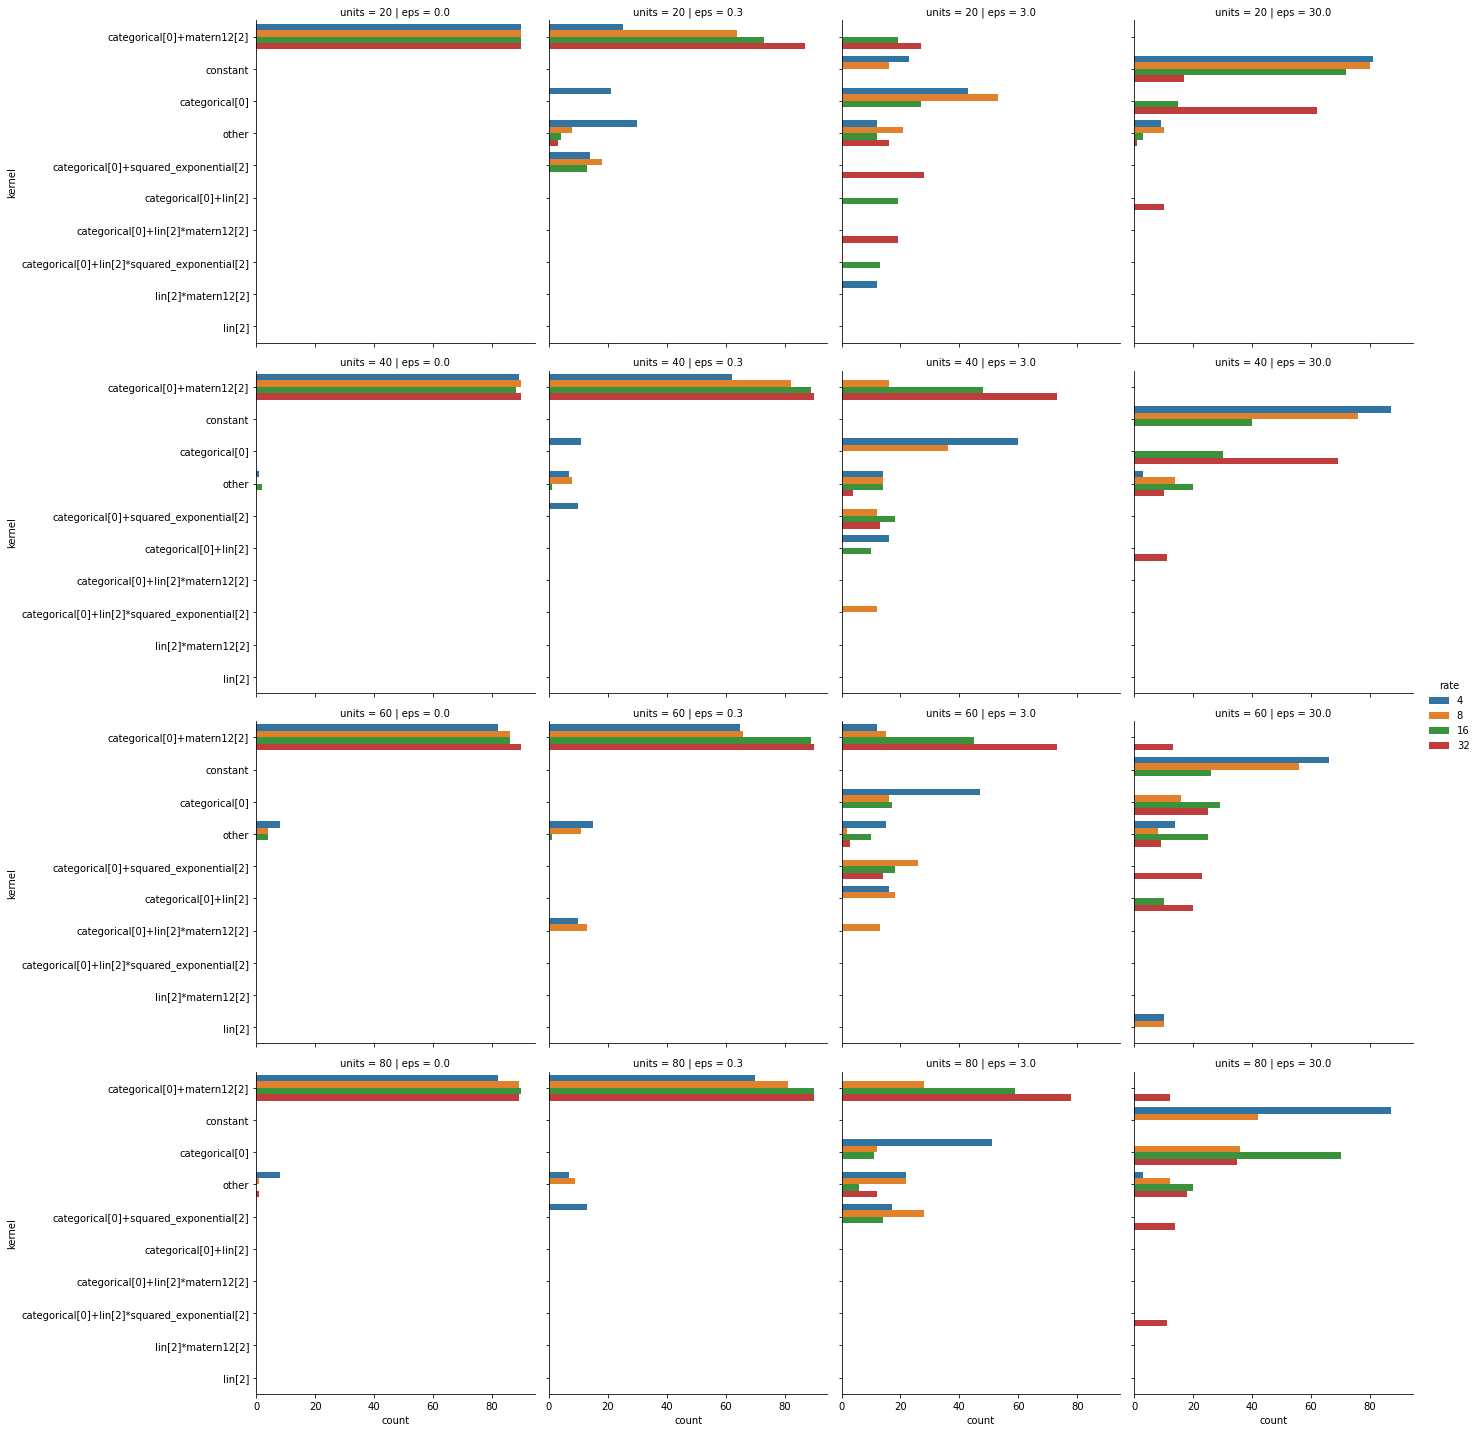

In [31]:
# Reformat and visualize output
true_kernels = pd.DataFrame({
    'output': ['y1', 'y2', 'y3', 'y4'],
    'kernel': ['categorical[0]+matern12[2]',
        'categorical[0]*matern12[2]+periodic[2]',
        'categorical[0]+categorical[1]*linear[2]',
        'categorical[0]+categorical[0]*squared_exponential[2]+categorical[1]*polynomial[2]']
})

# Split final kernels, expand to each row, and then count number of occurrences
sim_results['kernel_parts'] = [x.split('+') for x in sim_results.kernel]
sim_results_long = sim_results.drop(columns=['kernel', 'model']).explode('kernel_parts')
# sim_results_long_agg = sim_results_long. \
    # groupby(['rate', 'eps', 'output', 'kernel_parts']). \

sim_results_long_agg = sim_results. \
    groupby(['rate', 'eps', 'output', 'units', 'kernel']). \
    size(). \
    reset_index(name='count'). \
    sort_values('count', ascending=False)
# Bucket unlikely results together
# sim_results_long_agg. \
#     loc[(sim_results_long_agg['count'] < 5).values, 'kernel_parts'] = 'other'
sim_results_long_agg. \
    loc[(sim_results_long_agg['count'] < 10).values, 'kernel'] = 'other'
    
# groupby(['rate', 'eps', 'output', 'kernel_parts']). \
sim_results_long_agg = sim_results_long_agg. \
    groupby(['rate', 'eps', 'output', 'units', 'kernel']). \
    sum(). \
    reset_index(). \
    sort_values('count', ascending=False)

sns.catplot(
    data=sim_results_long_agg.query("output == 'y1'"),
    x='count',
    # y='kernel_parts',
    y='kernel',
    col='eps', #'output',
    hue='rate',
    row='units', #'output', #'eps',
    kind='bar',
    # row_order=['y1', 'y2', 'y3', 'y4'],
    # sharey=False
);

<AxesSubplot:xlabel='rate-eps-units-output', ylabel='None-kernel_parts'>

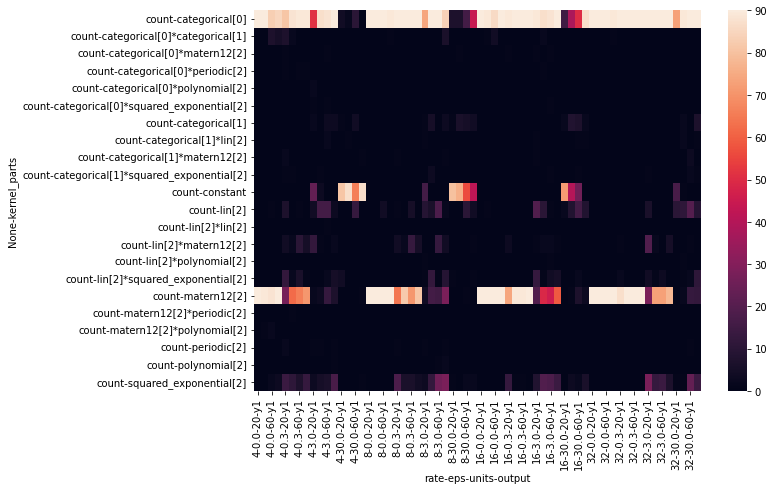

In [33]:
plt.subplots(figsize=(10,7))
sns.heatmap(
    sim_results_long.drop(columns=["iter"]).\
    query("output == 'y1'").\
    groupby(["rate", "eps", "units", "output", "kernel_parts"], as_index=False).\
    value_counts().\
    pivot_table(index=["rate", "eps", "units", "output"],
                columns=["kernel_parts"],
                values=["count"],
                fill_value=0).T
)

<AxesSubplot:xlabel='rate-eps-units-output', ylabel='None-kernel_parts'>

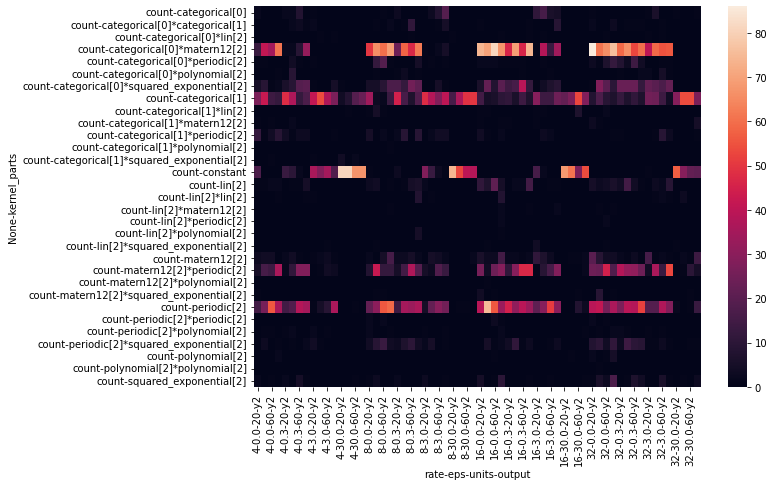

In [34]:
plt.subplots(figsize=(10,7))
sns.heatmap(
    sim_results_long.drop(columns=["iter"]).\
    query("output == 'y2'").\
    groupby(["rate", "eps", "units", "output", "kernel_parts"], as_index=False).\
    value_counts().\
    pivot_table(index=["rate", "eps", "units", "output"],
                columns=["kernel_parts"],
                values=["count"],
                fill_value=0).T
)

<AxesSubplot:xlabel='rate-eps-units-output', ylabel='None-kernel_parts'>

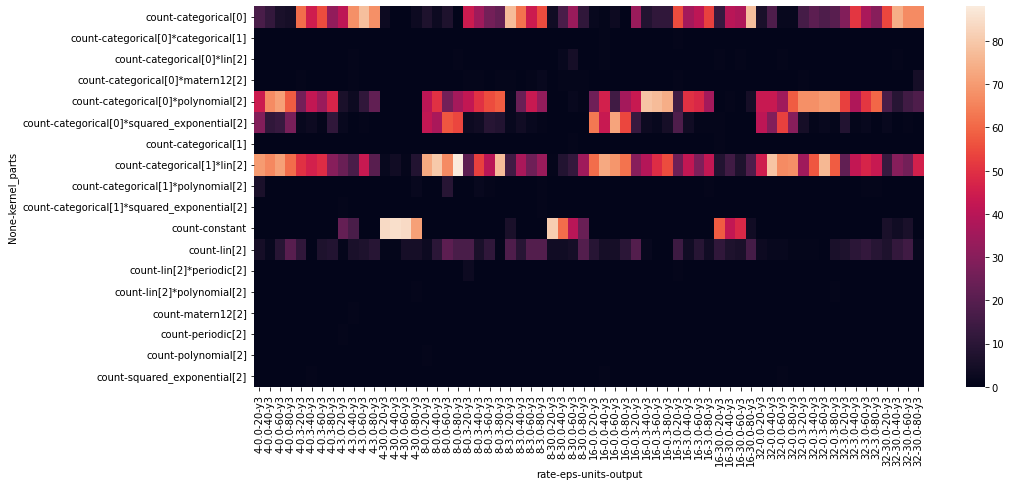

In [35]:
plt.subplots(figsize=(15,7))
sns.heatmap(
    sim_results_long.drop(columns=["iter"]).\
    query("output == 'y3'").\
    groupby(["rate", "eps", "units", "output", "kernel_parts"], as_index=False).\
    value_counts().\
    pivot_table(index=["rate", "eps", "units", "output"],
                columns=["kernel_parts"],
                values=["count"],
                fill_value=0).T
)

<AxesSubplot:xlabel='eps-units-rate', ylabel='None-kernel_parts'>

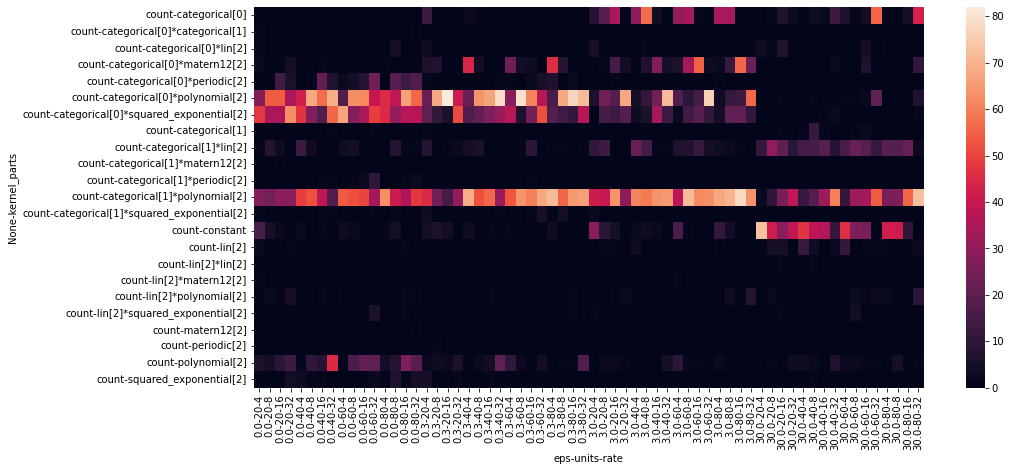

In [36]:
plt.subplots(figsize=(15,7))
sns.heatmap(
    sim_results_long.\
    query("output == 'y4'").\
    drop(columns=["iter", "output"]).\
    groupby(["rate", "eps", "units", "kernel_parts"], as_index=False).\
    value_counts().\
    pivot_table(index=["eps", "units", "rate"],
                columns=["kernel_parts"],
                values=["count"],
                fill_value=0).T
)

In [37]:
true_kernels

output                                             kernel
0     y1                         categorical[0]+matern12[2]
1     y2             categorical[0]*matern12[2]+periodic[2]
2     y3            categorical[0]+categorical[1]*linear[2]
3     y4  categorical[0]+categorical[0]*squared_exponent...

In [38]:
(sim_results
 .assign(output = ["y"+str(int(x[1])+1) for x in sim_results.output])
 .merge(true_kernels.rename(columns={"kernel": "true_kernel"}))
 .query("output == 'y4'")
 .kernel
 .value_counts()
)

categorical[0]*polynomial[2]                                                 1118
categorical[0]*polynomial[2]+categorical[1]*lin[2]                           1017
categorical[0]+categorical[1]*lin[2]                                          908
constant                                                                      744
categorical[0]                                                                650
categorical[0]*squared_exponential[2]+categorical[1]*lin[2]                   478
categorical[0]+lin[2]                                                         303
categorical[0]*squared_exponential[2]                                         190
categorical[1]*lin[2]                                                         101
categorical[0]*squared_exponential[2]+categorical[1]*lin[2]+lin[2]             84
lin[2]                                                                         63
categorical[0]*matern12[2]                                                     16
categorical[0]*p

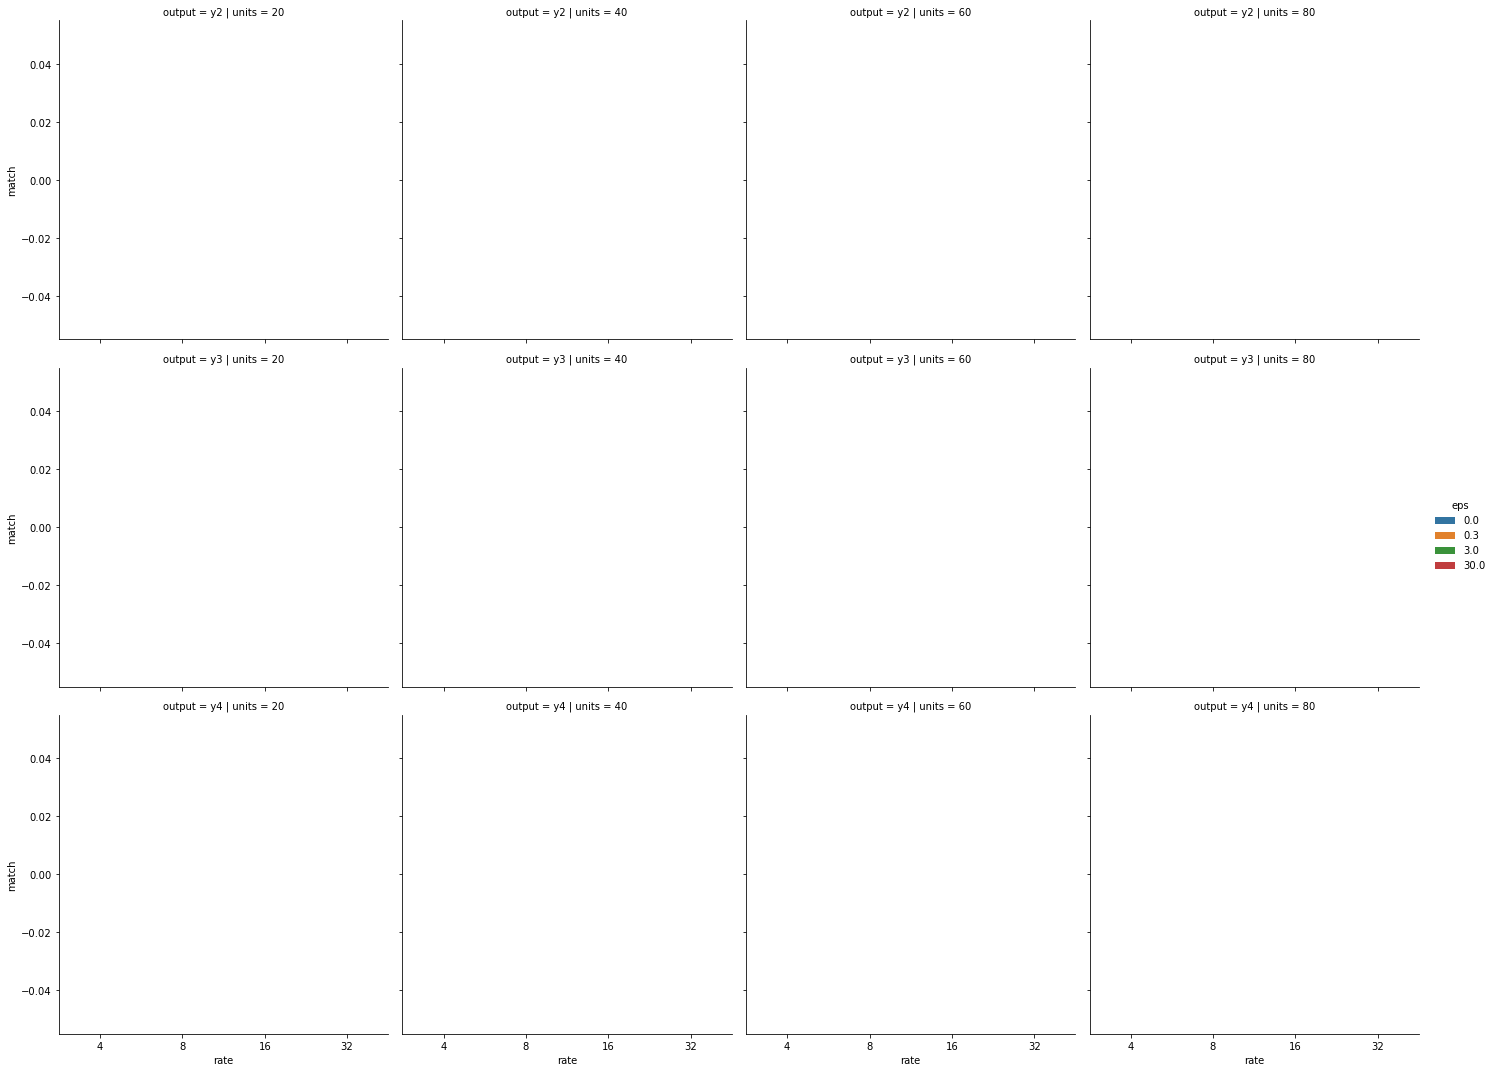

In [39]:
# How often do we get the kernel exactly correct?
sns.catplot(
    x="rate",
    y="match",
    hue="eps",
    col="units",
    row="output",
    kind="bar",
    data=(sim_results
 .assign(output = ["y"+str(int(x[1])+1) for x in sim_results.output])
 .merge(true_kernels.rename(columns={"kernel": "true_kernel"}))
 .assign(match = lambda df: df.kernel == df.true_kernel)
 .groupby(["output", "rate", "units", "eps"], as_index=False)
 .match
 .mean()
)
)

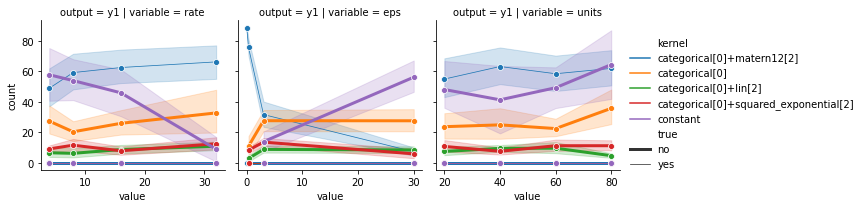

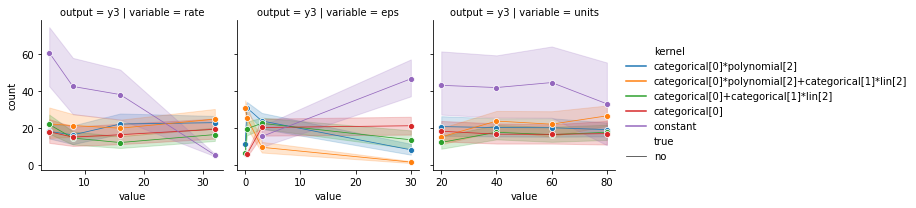

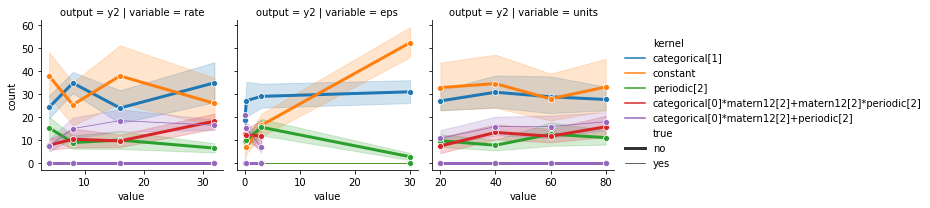

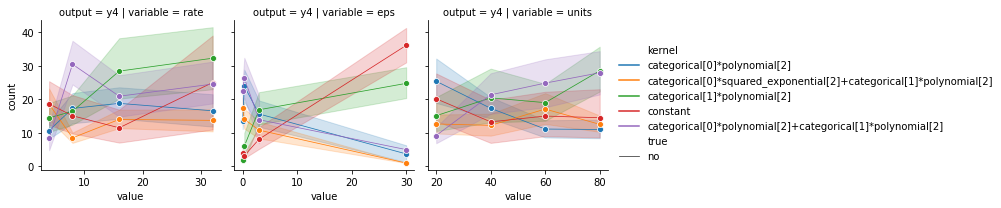

In [40]:
# Gather the top 5 kernels for each output
top_kernels = sim_results.\
    groupby(['output', 'kernel'], as_index=False).\
    size().\
    sort_values('size', ascending=False).\
    groupby(['output']).\
    head(5).\
    merge(true_kernels.assign(true='yes'), on=['output', 'kernel'], how='left').\
    fillna('no')

# First we want to get the number of times a kernel shows up for each set of parameters
# Then we want to get the number of times a kernel shows up at all for an output (to subset to most common)
# And finally then we want to subset to the top 5 kernels for each output
sim_results_top_k_plot_data = sim_results. \
    groupby(['rate', 'eps', 'output', 'units', 'kernel']). \
    size(). \
    reset_index(name='count'). \
    sort_values('count', ascending=False).\
    merge(top_kernels, on=['output', 'kernel'], how='inner')

for y in sim_results_long_agg.output.unique():
    grid = sns.FacetGrid(
        sim_results_top_k_plot_data. \
            query("output == '"+y+"'"). \
            groupby(['rate', 'eps', 'output', 'units', 'kernel', 'true']). \
            sum(). \
            unstack(fill_value=0). \
            stack(). \
            reset_index(). \
            melt(id_vars=['kernel', 'count', 'output', 'true'], value_vars=['rate', 'eps', 'units']),
        col="variable",
        row="output",
        sharex=False,
    )

    grid.map(
        sns.lineplot,
        "value",
        "count",
        "kernel",
        "true",
        marker='o',
        #sizes=[1,3],
        seed=9102,
        n_boot=500,
        ci=80
    )

    grid.add_legend()

    plt.show()


In [16]:
sim_results

index  rate  eps  units  iter output                        kernel  \
0         0     8  3.0     10    22     y0                     linear[2]   
1         1     8  3.0     10    22     y1                      constant   
2         2     8  3.0     10    22     y2                      constant   
3         3     8  3.0     10    22     y3  categorical[1]*polynomial[2]   
4         0     8  3.0     30    11     y0                categorical[0]   
...     ...   ...  ...    ...   ...    ...                           ...   
8995      3    16  3.0     10    13     y3  categorical[1]*polynomial[2]   
8996      0     2  3.0     30     4     y0                      constant   
8997      1     2  3.0     30     4     y1                      constant   
8998      2     2  3.0     30     4     y2                     linear[2]   
8999      3     2  3.0     30     4     y3  categorical[1]*polynomial[2]   

                                                  model  \
0     {'kernel': <gpflow.kernels.linears.Linear obje...   
1     {'kernel': <gpflow.kernels.statics.Constant ob...   
2     {'kernel': <gpflow.kernels.statics.Constant ob...   
3     {'kernel': <gpflow.kernels.base.Product object...   
4     {'kernel': <helper_functions.Categorical objec...   
...                                                 ...   
8995  {'kernel': <gpflow.kernels.base.Product object...   
8996  {'kernel': <gpflow.kernels.statics.Constant ob...   
8997  {'kernel': <gpflow.kernels.statics.Constant ob...   
8998  {'kernel': <gpflow.kernels.linears.Linear obje...   
8999  {'kernel': <gpflow.kernels.base.Product object...   

                        kernel_parts  lik_variance  
0                        [linear[2]]      6.057404  
1                         [constant]      7.333082  
2                         [constant]      6.645126  
3     [categorical[1]*polynomial[2]]      7.781664  
4                   [categorical[0]]      8.126583  
...                              ...           ...  
8995  [categorical[1]*polynomial[2]]      8.348972  
8996                      [constant]      6.450827  
8997                      [constant]      9.423104  
8998                     [linear[2]]     10.202432  
8999  [categorical[1]*polynomial[2]]      8.969428  

[9000 rows x 10 columns]

In [24]:
sim_results_top_k_plot_data.query("output == 'y0'")[['kernel','rate','count']].groupby(['kernel']).head()

kernel  rate  count
0               categorical[0]+matern12[2]    16     50
1               categorical[0]+matern12[2]    16     50
2               categorical[0]+matern12[2]    32     50
3               categorical[0]+matern12[2]    32     48
4               categorical[0]+matern12[2]    32     47
69   categorical[0]+squared_exponential[2]     8     29
70   categorical[0]+squared_exponential[2]     4     16
71   categorical[0]+squared_exponential[2]    16     10
72   categorical[0]+squared_exponential[2]     8      8
73   categorical[0]+squared_exponential[2]     2      7
127               categorical[0]+linear[2]     2     22
128               categorical[0]+linear[2]     2      4

In [26]:
pd.merge(sim_results_top_k_plot_data.kernel, sim_results_top_k_plot_data.rate, how="outer")

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

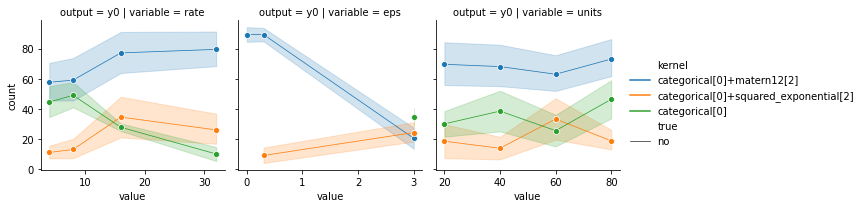

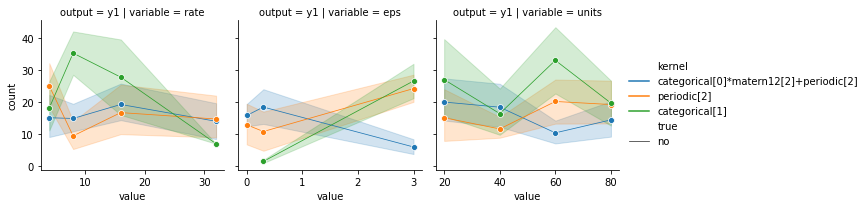

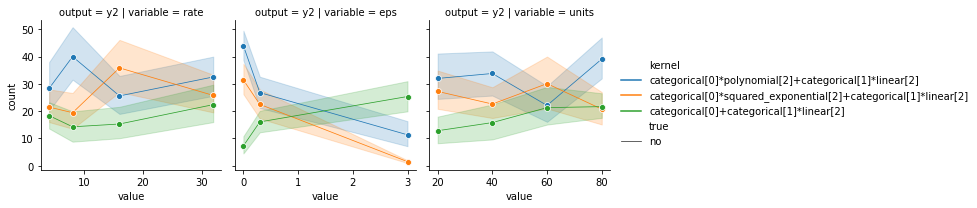

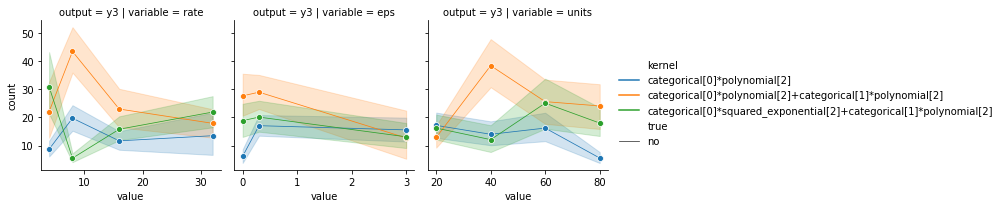

In [29]:
# Can we do this for just the low and medium noise settings?
sim_results_low_noise = sim_results.query("eps != 30.0")

# Gather the top 5 kernels for each output
top_kernels = sim_results_low_noise.\
    groupby(['output', 'kernel'], as_index=False).\
    size().\
    sort_values('size', ascending=False).\
    groupby(['output']).\
    head(3).\
    merge(true_kernels.assign(true='yes'), on=['output', 'kernel'], how='left').\
    fillna('no')

# First we want to get the number of times a kernel shows up for each set of parameters
# Then we want to get the number of times a kernel shows up at all for an output (to subset to most common)
# And finally then we want to subset to the top 5 kernels for each output
sim_results_top_k_plot_data = sim_results_low_noise. \
    groupby(['rate', 'eps', 'output', 'units', 'kernel']). \
    size(). \
    reset_index(name='count'). \
    sort_values('count', ascending=False).\
    merge(top_kernels, on=['output', 'kernel'], how='inner')

for y in sim_results_long_agg.output.unique():
    grid = sns.FacetGrid(
        sim_results_top_k_plot_data. \
            query("output == '"+y+"'"). \
            groupby(['rate', 'eps', 'output', 'units', 'kernel', 'true']). \
            sum(). \
            unstack(fill_value=0). \
            stack(). \
            reset_index(). \
            melt(id_vars=['kernel', 'count', 'output', 'true'], value_vars=['rate', 'eps', 'units']),
        col="variable",
        row="output",
        sharex=False,
    )

    grid.map(
        sns.lineplot,
        "value",
        "count",
        "kernel",
        "true",
        marker='o',
        #sizes=[1,3],
        seed=9102,
        n_boot=500,
        ci=80
    )

    grid.add_legend()

    plt.show()


In [88]:
# Pull off the variance of the likelihood and add as a separate column in simulation set
sim_results.reset_index(inplace=True)
sim_results['lik_variance'] = [sim_results['model'][x]['model'].likelihood.variance.numpy().flatten()[0] for x in range(sim_results.shape[0])]

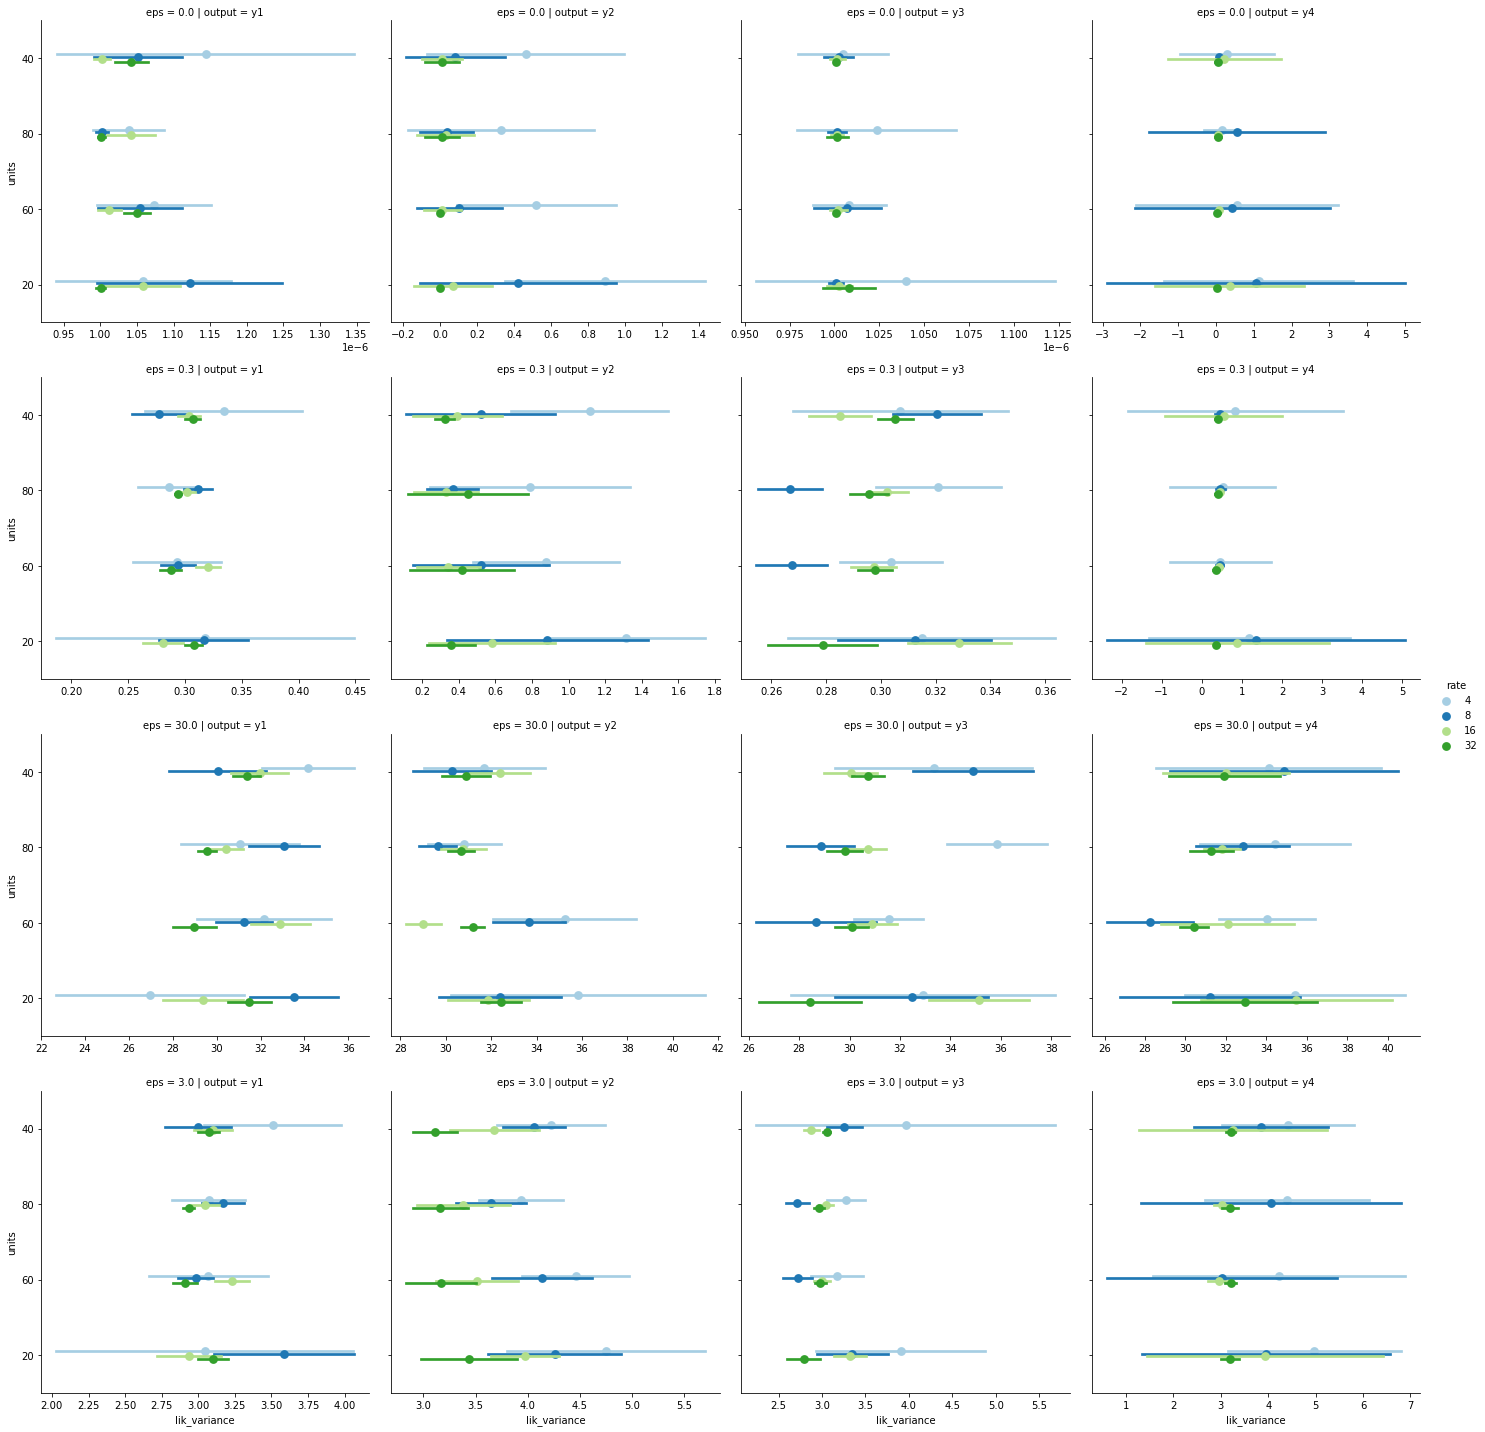

In [89]:
sns.catplot(
    x="lik_variance", 
    y="units",
    hue="rate", 
    col="output",
    row="eps",
    data=sim_results.assign(units = sim_results.units.apply(str),
                            eps = sim_results.eps.apply(str)), 
    kind="point",
    dodge=True,
    # n_boot=50,
    ci='sd',
    sharex=False,
    join=False,
    palette='Paired'
);

In [35]:
sim_results_long_agg

rate   eps output  units                      kernel  count
619    16  30.0     y0     80                    constant    100
620    16  30.0     y1     20                    constant    100
229     8   0.0     y0     80  categorical[0]+matern12[2]    100
287     8   0.3     y0     80  categorical[0]+matern12[2]    100
629    16  30.0     y2     80                    constant    100
..    ...   ...    ...    ...                         ...    ...
407     8  30.0     y0     20                       other      1
42      4   0.0     y2     80                       other      1
667    32   0.0     y2     40                       other      1
697    32   0.3     y0     40                       other      1
846    32  30.0     y3     80                       other      1

[847 rows x 6 columns]

In [45]:
sim_results[(sim_results.output == "y1") & (sim_results.eps == 0.3) & (sim_results.rate == 32)]

index  rate  eps  units  iter output  \
33         1    32  0.3     40    63     y1   
93         1    32  0.3     40    81     y1   
217        1    32  0.3     80    45     y1   
265        1    32  0.3     20    27     y1   
285        1    32  0.3     20    81     y1   
...      ...   ...  ...    ...   ...    ...   
25365      1    32  0.3     80    80     y1   
25469      1    32  0.3     20    20     y1   
25477      1    32  0.3     60    90     y1   
25505      1    32  0.3     40    10     y1   
25577      1    32  0.3     20    70     y1   

                                                  kernel  \
33                categorical[0]*matern12[2]+periodic[2]   
93      categorical[0]*matern12[2]+periodic[2]+linear[2]   
217    categorical[0]*matern12[2]+periodic[2]+categor...   
265               categorical[0]*matern12[2]+periodic[2]   
285               categorical[0]*matern12[2]+periodic[2]   
...                                                  ...   
25365  categorical[0]*matern12[2]+periodic[2]+categor...   
25469  categorical[0]*matern12[2]+periodic[2]+categor...   
25477  categorical[0]*periodic[2]+squared_exponential...   
25505  categorical[0]*matern12[2]+matern12[2]*squared...   
25577             categorical[0]*matern12[2]+periodic[2]   

                                                   model  \
33     {'kernel': <gpflow.kernels.base.Sum object at ...   
93     {'kernel': <gpflow.kernels.base.Sum object at ...   
217    {'kernel': <gpflow.kernels.base.Sum object at ...   
265    {'kernel': <gpflow.kernels.base.Sum object at ...   
285    {'kernel': <gpflow.kernels.base.Sum object at ...   
...                                                  ...   
25365  {'kernel': <gpflow.kernels.base.Sum object at ...   
25469  {'kernel': <gpflow.kernels.base.Sum object at ...   
25477  {'kernel': <gpflow.kernels.base.Sum object at ...   
25505  {'kernel': <gpflow.kernels.base.Sum object at ...   
25577  {'kernel': <gpflow.kernels.base.Sum object at ...   

                                            kernel_parts  lik_variance  
33             [categorical[0]*matern12[2], periodic[2]]      0.090908  
93     [categorical[0]*matern12[2], periodic[2], line...      0.092585  
217    [categorical[0]*matern12[2], periodic[2], cate...      0.089655  
265            [categorical[0]*matern12[2], periodic[2]]      0.105658  
285            [categorical[0]*matern12[2], periodic[2]]      0.105658  
...                                                  ...           ...  
25365  [categorical[0]*matern12[2], periodic[2], cate...      0.085393  
25469  [categorical[0]*matern12[2], periodic[2], cate...      0.086580  
25477  [categorical[0]*periodic[2], squared_exponenti...      0.163590  
25505  [categorical[0]*matern12[2], matern12[2]*squar...      0.096075  
25577          [categorical[0]*matern12[2], periodic[2]]      0.105658  

[400 rows x 10 columns]

<AxesSubplot:xlabel='count', ylabel='kernel'>

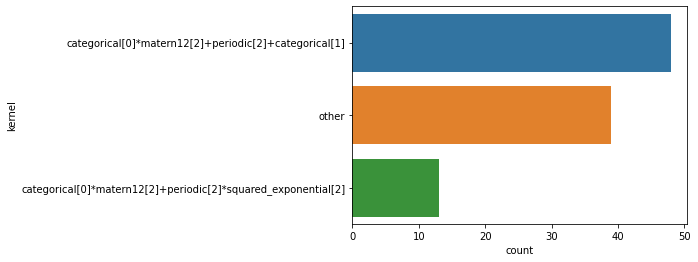

In [46]:
# Show all of the kernels for Y1 with a small amount of noise added
sns.barplot(
    y="kernel",
    x="count",
    data=sim_results_long_agg[(sim_results_long_agg.output == "y1") & (sim_results_long_agg.eps == 0.3) & (sim_results_long_agg.rate == 32) & (sim_results_long_agg.units == 80)]
)

### Individual splitting

In [4]:
samp_df = sim_data(rate=20,
                   num_units=50,
                   fixed_num=True,
                   include_output=True,
                   kern_out=kernel_dictionary,
                   set_seed=True,
                   eps=0.1)

In [5]:
samp_df

id  treat  time        y1        y2        y3         y4
0     0.0    0.0   0.8 -0.403505 -1.740430  0.219321   1.558011
1     0.0    0.0   1.0 -0.384368 -2.016143  0.306913   2.082773
2     0.0    0.0   1.5 -1.146688 -1.203751  0.571485   1.434307
3     0.0    0.0   2.7  0.143024 -2.152576  0.915007   0.713268
4     0.0    0.0   2.8  0.566962 -2.382068  1.091982   0.837487
..    ...    ...   ...       ...       ...       ...        ...
995  49.0    1.0   9.5 -0.388479 -3.050735 -1.324360  11.831224
996  49.0    1.0  10.1  1.039816 -2.195747 -1.469057  13.943111
997  49.0    1.0  10.8  0.680261 -0.306518 -1.654922  16.570543
998  49.0    1.0  11.4  0.141867 -1.354302 -1.834372  21.272711
999  49.0    1.0  11.8  0.857068 -1.753086 -1.627686  24.615195

[1000 rows x 7 columns]

In [ ]:
# from gpflow.optimizers import Adam, NaturalGradient
m_test = gpflow.models.GPR(
    data = (samp_df[['id', 'treat', 'time']].to_numpy().reshape(-1, 3), samp_df['y1'].to_numpy().reshape(-1, 1)),
    kernel = Categorical(active_dims=[0])+gpflow.kernels.Matern12(active_dims=[2])
)

# natgrad_opt = NaturalGradient(gamma=1.0)
# variational_params = [(vgp.q_mu, vgp.q_sqrt)]
# natgrad_opt.minimize(vgp.training_loss, var_list=variational_params)

for i in range(1000):
    tf.optimizers.Adam(learning_rate=0.1, epsilon=0.1).minimize(m_test.training_loss, m_test.trainable_variables)
    # natgrad_opt.minimize(m_test.training_loss, m_test.trainable_variables)
    likelihood = m_test.training_loss()
    # adam_opt_for_vgp.minimize(vgp.training_loss, var_list=vgp.trainable_variables)
    # likelihood = vgp.elbo()
    if i % 50 == 0:
        tf.print(f"GRP Likelihood Loss with Adam: iteration {i + 1} likelihood {likelihood:.04f}")

In [46]:
%%time
split_results = [split_kernel_search(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df['y'+str(x)],
    cat_vars=[0, 1],
    random_seed=9102,
    unit_idx=0,
    kern_list=[
        gpflow.kernels.SquaredExponential(),
        gpflow.kernels.Matern12(),
        gpflow.kernels.Linear(),
        gpflow.kernels.Polynomial(),
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
    ],
    verbose=True,
    keep_only_best=True,
    prune=True
) for x in range(1,5)]

Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
No better kernel found in layer, exiting search!
Pruning now
categorical[0]+matern12[2]
Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
-----------

Working on depth 4 now
No better kernel found in layer, exiting search!
Pruning now
New best log likelihood: -1005.7397843393464
New best log likelihood: -1005.7397843349992
Model: ['periodic', 'categorical'], BIC: 2037.68
categorical[0]*matern12[2]+periodic[2]
Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
No better kernel found in layer, exiting search!
Pruning now
categorical[0]*polynomial[2]
Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
-----------

Working on depth 4 now
-----------

Working on depth 5 now
No better kernel found in layer, exiting search!
Pruning now
New best log likelihood: -1016.813

In [8]:
%%time
split_y1_new = split_kernel_search(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df['y1'],
    cat_vars=[0, 1],
    random_seed=9102,
    unit_idx=0,
    kern_list=[gpflow.kernels.SquaredExponential(), gpflow.kernels.Matern12()],
    verbose=True,
    # debug=True,
    keep_only_best=False,
    prune=True,
    metric_diff=10
)

Working on depth 1 now
-----------

Working on depth 2 now


/Users/allen/Documents/Academics/GW/research/projects/waveome/kernel_learning/helper_functions.py:678: RuntimeWarning: overflow encountered in exp
  return np.exp(x)


-----------

Working on depth 3 now
No better kernel found in layer, exiting search!
Pruning now
categorical[0]+matern12[2]
CPU times: user 2min 45s, sys: 27.5 s, total: 3min 12s
Wall time: 1min 5s


In [9]:
[(k, x['bic']) for k, x in split_y1_new['models'].items()]

[('categorical[0]', 2354.72),
 ('constant', 2919.79),
 ('categorical[1]', 2902.25),
 ('squared_exponential[2]', 2654.31),
 ('matern12[2]', 2661.27),
 ('categorical[0]+categorical[1]', 2361.21),
 ('categorical[0]+squared_exponential[2]', -122.58),
 ('categorical[0]+matern12[2]', -348.73),
 ('categorical[0]*categorical[1]', 2354.72),
 ('categorical[0]*squared_exponential[2]', 1879.07),
 ('categorical[0]*matern12[2]', 1685.65),
 ('categorical[0]+matern12[2]+categorical[1]', -342.18),
 ('categorical[0]+matern12[2]+squared_exponential[2]', -344.05),
 ('categorical[0]+categorical[0]*matern12[2]', 1666.5),
 ('categorical[0]*categorical[1]+matern12[2]', -348.73),
 ('categorical[0]+categorical[1]*matern12[2]', -8.95),
 ('categorical[0]*squared_exponential[2]+matern12[2]', inf),
 ('categorical[0]+matern12[2]*squared_exponential[2]', inf),
 ('categorical[0]*matern12[2]+matern12[2]', -331.41),
 ('categorical[0]+matern12[2]*matern12[2]', -342.18)]

In [37]:
split_y1_new['models'][split_y1_new['best_model']]['model']

<gpflow.models.gpr.GPR object at 0x2890c9b50>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 2.08416   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 1.21849   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 1.07529   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │ Gamma   │ True        │ ()      │ float64 │ 0.0101846 │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════╛

In [38]:
split_y1['models'][split_y1['best_model']]['model']

<gpflow.models.gpr.GPR object at 0x297182760>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.34031   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.78816   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.60845   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0101858 │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════╛

In [7]:
%%time
split_y1 = split_kernel_search(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df['y1'],
    cat_vars=[0, 1],
    random_seed=9102,
    unit_idx=0,
    kern_list=[gpflow.kernels.SquaredExponential(), gpflow.kernels.Matern12()],
    verbose=True,
    keep_only_best=False,
    prune=True
)

Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
No better kernel found in layer, exiting search!
Pruning now
categorical[0]+matern12[2]
CPU times: user 3min 1s, sys: 48.3 s, total: 3min 49s
Wall time: 1min 21s


In [9]:
split_y1['best_model']

'categorical[0]+matern12[2]'

/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<AxesSubplot:xlabel='time'>

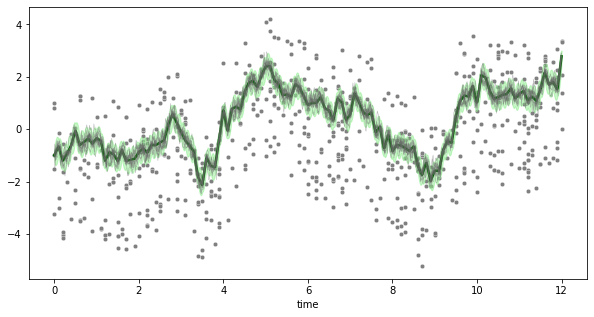

In [10]:
gp_predict_fun(split_y1['models'][split_y1['best_model']]['model'], 2, 0, ['id','treat','time'])

/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id] (57.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'matern12[time] (43.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='time'>],
       dtype=object))

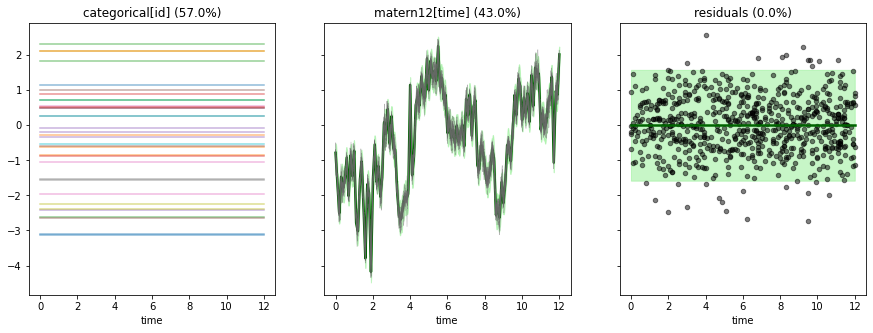

In [11]:
pred_kernel_parts(
    m=split_y1['models'][split_y1['best_model']]['model'], 
    k_names=split_y1['best_model'],
    time_idx=2, 
    unit_idx=0, 
    col_names=['id','treat','time']
)

In [44]:
kernel_list = [
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern12(),
    gpflow.kernels.Linear(),
    gpflow.kernels.Polynomial(),
    #gpflow.kernels.ArcCosine(),
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
]

split_out = Parallel(n_jobs=4, verbose=1)(
    delayed(split_kernel_search)(
        X=samp_df[['id', 'treat', 'time']],
        Y=samp_df.drop(columns=['id', 'treat', 'time']).iloc[:, i],
        kern_list=kernel_list,
        cat_vars=[0, 1],
        unit_idx=0,
        max_depth=5,
        early_stopping=True,
        prune=True,
        keep_all=False,
        keep_only_best=False,
        lik='gaussian',
        random_seed=9102,
        num_restarts=3
    )
    for i in range(4)
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 29.6min remaining: 29.6min



systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 41.9min finished



systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [126]:
kernel_list = [
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern12(),
    gpflow.kernels.Linear(),
    #gpflow.kernels.Polynomial(),
    #gpflow.kernels.ArcCosine(),
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
]

split_out = Parallel(n_jobs=4, verbose=1)(
    delayed(split_kernel_search)(
        X=samp_df[['id', 'treat', 'time']],
        Y=samp_df.drop(columns=['id', 'treat', 'time']).iloc[:, i],
        kern_list=kernel_list,
        cat_vars=[0, 1],
        unit_idx=0,
        max_depth=5,
        early_stopping=True,
        prune=True,
        keep_all=False,
        keep_only_best=False,
        lik='gaussian',
        random_seed=9102,
        num_restarts=1
    )
    for i in range(4)
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 57.9min remaining: 57.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 79.9min finished


In [127]:
[split_out[x]['best_model'] for x in range(4)]

['categorical[0]+matern12[2]',
 'categorical[0]*matern12[2]+categorical[0]*matern12[2]+periodic[2]',
 'categorical[0]*squared_exponential[2]+categorical[0]*linear[2]+linear[2]',
 'categorical[0]*squared_exponential[2]+categorical[1]*squared_exponential[2]']

In [6]:
%%time
y2_search = split_kernel_search(
    X=samp_df[['id', 'treat', 'time']],
    Y=samp_df.drop(columns=['id', 'treat', 'time']).iloc[:, 1],
    kern_list=[
        gpflow.kernels.SquaredExponential(),
        gpflow.kernels.Matern12(),
        gpflow.kernels.Linear(),
        gpflow.kernels.Polynomial(),
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
    ],
    cat_vars=[0, 1],
    unit_idx=0,
    max_depth=5,
    early_stopping=True,
    prune=True,
    keep_all=False,
    keep_only_best=False,
    lik='gaussian',
    random_seed=9102
)

CPU times: user 11min 54s, sys: 3min 26s, total: 15min 20s
Wall time: 4min 48s


In [7]:
y2_search['best_model']

'categorical[0]*matern12[2]+periodic[2]'

In [8]:
y2_search['models'][y2_search['best_model']]['model']

<gpflow.models.gpr.GPR object at 0x16cab5b80>
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance      │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1          │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].kernels[1].variance      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.89528    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].kernels[1].lengthscales  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.8039     │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.68225    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.85359    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].period                   │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.07532    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.likelihood.variance                        │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.00668504 │
╘════════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════╛

In [38]:
k2

<gpflow.kernels.base.Sum object at 0x163a17a30>
╒═════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                    │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].kernels[0].variance      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].kernels[0].lengthscales  │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │     0.5 │
├─────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].kernels[1].variance      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].base_kernel.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │     2   │
├─────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].base_kernel.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].period                   │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │     3   │
╘═════════════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛

/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gp/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*matern12[time] (52.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'periodic[time] (48.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='time'>],
       dtype=object))

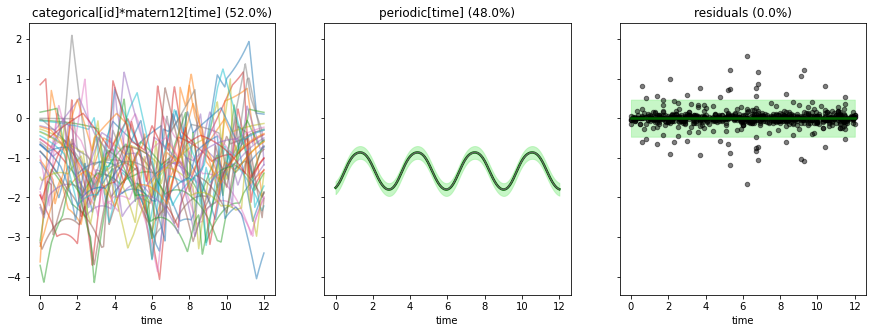

In [9]:
pred_kernel_parts(
    m=y2_search['models'][y2_search['best_model']]['model'],
    k_names=y2_search['best_model'],
    time_idx=2,
    unit_idx=0,
    col_names=['id', 'treat', 'time']
)

In [11]:
[split_out[x]['best_model'] for x in range(4)]

['categorical[0]+matern12[2]',
 'categorical[0]*matern12[2]+matern12[2]',
 'categorical[0]*squared_exponential[2]+categorical[1]*linear[2]',
 'categorical[0]*matern12[2]+categorical[1]*squared_exponential[2]']

In [12]:
split_out[3]['models'][split_out[3]['best_model']]['model']

<gpflow.models.gpr.GPR object at 0x2dc04bac0>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │    1         │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  108.293     │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   54.675     │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1219.68      │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    9.88015   │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].kernels[1].variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │    1         │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance                       │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │    0.0101662 │
╘═══════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════════╛

(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*squared_exponential[time] (100.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'categorical[treat]*linear[time] (0.0%)'}, xlabel='time'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='time'>],
       dtype=object))

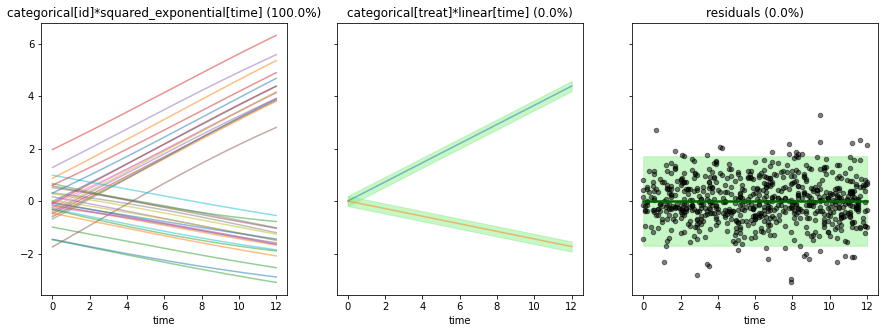

In [13]:
pred_kernel_parts(
    m=split_out[2]['models'][split_out[2]['best_model']]['model'],
    k_names=split_out[2]['best_model'],
    time_idx=2,
    unit_idx=0,
    col_names=['id', 'treat', 'time']
)

### Sparse approximation

In [11]:
X_test = samp_df.iloc[:, :3].to_numpy().reshape(-1, 3)
Y_test = samp_df['y4'].to_numpy().reshape(-1, 1)
X_iv = samp_df.groupby('id').sample(n=10).iloc[:, :3].to_numpy().reshape(-1, 3)

In [12]:
# Get five observations per individual unit ID
iv_idx = np.concatenate([np.random.choice(np.asarray(X_test[:, 0] == i).nonzero()[0], size=10, replace=False) for i in np.unique(X_test[:, 0])])

In [13]:
%%time
# create SVGP model as usual and optimize
m = gpflow.models.SGPR(data=(X_test, Y_test),
                   # kernel=gpflow.kernels.Linear(active_dims=[2])*Categorical(active_dims=[1])+Categorical(active_dims=[0]),
                   kernel=(Categorical(active_dims=[0]) +
      Categorical(active_dims=[1]) *
      gpflow.kernels.Polynomial(active_dims=[2]) +
      Categorical(active_dims=[0]) *
      gpflow.kernels.SquaredExponential(active_dims=[2])),
                   inducing_variable=X_test[iv_idx, :].copy())
opt_results = gpflow.optimizers.Scipy().minimize(
    m.training_loss,
    m.trainable_variables
)
print_summary(m)

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤════════════════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                  │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪════════════════════════╡
│ SGPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.45405370936198924    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼────────────────────────┤
│ SGPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.30122298139773834    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼───────

<AxesSubplot:xlabel='c'>

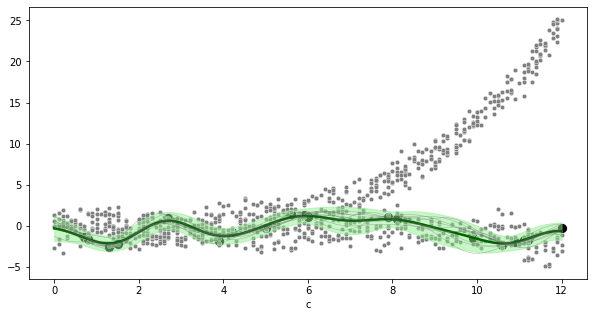

In [14]:
gp_predict_fun(gp=m, x_idx=2, unit_idx=0, col_names=['a', 'b', 'c'], unit_label=1)
#plt.plot(X_test[:50, 2], np.repeat(0, 50), 'o')
#plt.plot(m.inducing_variable.Z.numpy()[:, 2], np.repeat(0, 50), 'o')

In [15]:
%%time
# Try same model without inducing points
m2 = gpflow.models.GPR(data=(X_test, Y_test),
                       # kernel=gpflow.kernels.Linear(active_dims=[2])*Categorical(active_dims=[1])+Categorical(active_dims=[0])
                        kernel=(Categorical(active_dims=[0]) +
      Categorical(active_dims=[1]) *
      gpflow.kernels.Polynomial(active_dims=[2]) +
      Categorical(active_dims=[0]) *
      gpflow.kernels.SquaredExponential(active_dims=[2])),
                      )
print_summary(m2)
opt_results = gpflow.optimizers.Scipy().minimize(
    m2.training_loss,
    m2.trainable_variables
)
print_summary(m2)

╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].kernels[1].variance     │ Param

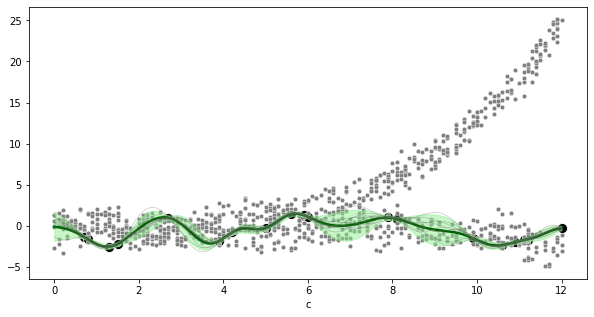

In [16]:
gp_predict_fun(gp=m2, x_idx=2, unit_idx=0, col_names=['a', 'b', 'c'], unit_label=1);

### Minibatching

In [113]:
%%time
m = gpflow.models.SVGP(#data=(X_test, Y_test),
                    likelihood=gpflow.likelihoods.Gaussian(),
                   kernel=gpflow.kernels.SquaredExponential(active_dims=[2]) + Categorical(active_dims=[0]),
                   inducing_variable=X_test.copy()
)
# opt_results = gpflow.optimizers.Scipy().minimize(
#     m.training_loss,
#     m.trainable_variables
# )
# m
tensor_data = tuple(map(tf.convert_to_tensor, (X_test, Y_test)))
m.elbo(tensor_data) 

CPU times: user 105 ms, sys: 9.68 ms, total: 115 ms
Wall time: 78.8 ms


<tf.Tensor: shape=(), dtype=float64, numpy=-1737.5039280012993>

In [ ]:
%%time
minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).repeat()#.shuffle(500)
train_iter = iter(train_dataset.batch(minibatch_size))
m.elbo(next(train_iter))

CPU times: user 76.9 ms, sys: 17.6 ms, total: 94.5 ms
Wall time: 62.4 ms


<tf.Tensor: shape=(), dtype=float64, numpy=-430.1403144310118>

In [118]:
minibatch_size = 100

# We turn off training for inducing point locations
#gpflow.set_trainable(m.inducing_variable, False)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

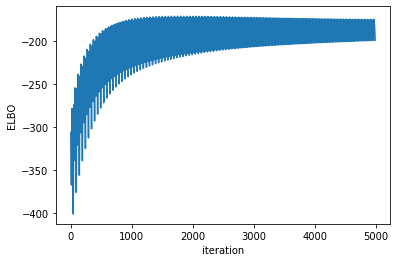

In [119]:
maxiter = ci_niter(5000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [120]:
m

<gpflow.models.svgp.SVGP object at 0x7fd5ffcc9fa0>
╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                                │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.866906807246735                                    │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 1.5840634905771478                                   │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.7041212551438445                                   │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()            │ float64 │ 1.6801200098280655                                   │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.inducing_variable.Z            │ Parameter │ Identity         │         │ True        │ (500, 3)      │ float64 │ [[0., 0., 0.24718353...                              │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.q_mu                           │ Parameter │ Identity         │         │ True        │ (500, 1)      │ float64 │ [[-7.97627348e-01...                                 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.q_sqrt                         │ Parameter │ FillTriangular   │         │ True        │ (1, 500, 500) │ float64 │ [[[5.91291451e-01, 0.00000000e+00, 0.00000000e+00... │
╘═════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═══════════════╧═════════╧══════════════════════════════════════════════════════╛

<AxesSubplot:>

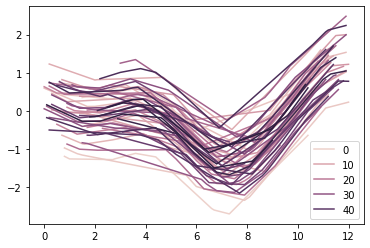

In [122]:
mu, var = m.predict_f(X_test)
# plt.plot(X_test[:, 2], mu, 'o')
sns.lineplot(x=X_test[:, 2],
             y=mu.numpy().flatten(),
             hue=X_test[:, 0])

In [132]:
Y_test.shape

(500, 1)

### ARD prefiltering

In [67]:
# Standardize X matrix to make all features on same scale
X_test = samp_df.iloc[:, :3].to_numpy().reshape(-1, 3)
X_test = (X_test - X_test.mean(axis=0))/(X_test.std(axis=0))
Y_test = samp_df['y4'].to_numpy().reshape(-1, 1) + np.random.normal(size=len(Y_test)).reshape(-1, 1)


In [69]:
(X_test, Y_test)

(array([[-1.67524673, -1.        , -1.75200948],
        [-1.67524673, -1.        , -1.63567032],
        [-1.67524673, -1.        , -1.60658554],
        ...,
        [ 1.67524673,  1.        ,  1.65091075],
        [ 1.67524673,  1.        ,  1.67999554],
        [ 1.67524673,  1.        ,  1.67999554]]),
 array([[-0.81802929],
        [-1.01932932],
        [-0.63501334],
        ...,
        [-0.78725812],
        [ 1.6449571 ],
        [ 0.73432376]]))

In [70]:
# X_test = samp_df.iloc[:, :3].to_numpy().reshape(-1, 3)
# Y_test = samp_df['y4'].to_numpy().reshape(-1, 1) + np.random.normal(size=len(Y_test)).reshape(-1, 1)
m_ard = gpflow.models.GPR(
    data=(X_test, Y_test),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=3*[1.], active_dims=[0,1,2])
)

# m_ard.kernel.variance.prior = tfd.Uniform(0, 5) #f64(0), f64(1))
# m_ard.kernel.lengthscales.prior = tfd.Gamma(f64(1), f64(1))

In [71]:
%%time
opt_results = gpflow.optimizers.Scipy().minimize(
    m_ard.training_loss,
    m_ard.trainable_variables
)

CPU times: user 5min 7s, sys: 6.96 s, total: 5min 14s
Wall time: 1min 15s


In [72]:
m_ard

<gpflow.models.gpr.GPR object at 0x2e3a34220>
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                              │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 6.824050355209864                  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (3,)    │ float64 │ [0.10412715 0.37195062 0.68152223] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.991931531464357                  │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════════════════════╛

In [89]:
# Now add kernel component for "best" feature, feature 0
m_ard = gpflow.models.GPR(
    data=(X_test, Y_test),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=2*[1.], active_dims=[1,2]) + 
        Categorical(active_dims=[0])
)

opt_results = gpflow.optimizers.Scipy().minimize(
    m_ard.training_loss,
    m_ard.trainable_variables
)
m_ard

<gpflow.models.gpr.GPR object at 0x2e3a492e0>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 15.428308474536625      │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [0.03415548 1.06424259] │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.06222332707226645     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 2.7641821990970152      │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════════╛

In [90]:
# Now add kernel component for "best" feature, feature 1
m_ard = gpflow.models.GPR(
    data=(X_test, Y_test),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=[1.], active_dims=[2]) + 
        Categorical(active_dims=[1]) +
        Categorical(active_dims=[0])
)
    
opt_results = gpflow.optimizers.Scipy().minimize(
    m_ard.training_loss,
    m_ard.trainable_variables
)
m_ard

<gpflow.models.gpr.GPR object at 0x16d00deb0>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.2687382113459407  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.86982479]        │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.49362030698981635 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.kernels[2].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.08396424901192738 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 3.832771366960048   │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════╛

In [82]:
# Now add kernel component for "best" feature
m_ard = gpflow.models.GPR(
    data=(X_test, Y_test),
    kernel=Categorical(active_dims=[1]) +
        Categorical(active_dims=[1])*Categorical(active_dims=[0]) + 
        Categorical(active_dims=[0])
)
    
opt_results = gpflow.optimizers.Scipy().minimize(
    m_ard.training_loss,
    m_ard.trainable_variables
)
m_ard

<gpflow.models.gpr.GPR object at 0x15ecc0430>
╒═══════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.kernels[0].variance            │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.190937  │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].kernels[0].variance │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.304977  │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].kernels[1].variance │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.304977  │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[2].variance            │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0896729 │
├───────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance                   │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 4.48842   │
╘═══════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════╛

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<AxesSubplot:xlabel='c'>

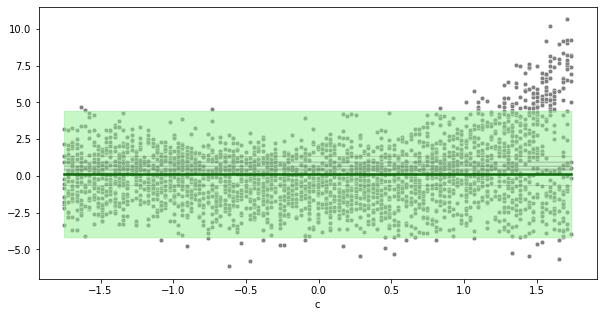

In [88]:
gp_predict_fun(gp=m_ard, x_idx=2, unit_idx=0, unit_label=0, col_names=['a', 'b', 'c'])

(<Figure size 1800x360 with 5 Axes>,
 array([<AxesSubplot:title={'center':'categorical[b] (0.0%)'}, xlabel='c'>,
        <AxesSubplot:title={'center':'categorical[b]*squared_exponential[c] (85.0%)'}, xlabel='c'>,
        <AxesSubplot:title={'center':'categorical[a] (0.0%)'}, xlabel='c'>,
        <AxesSubplot:title={'center':'categorical[a]*squared_exponential[c] (0.0%)'}, xlabel='c'>,
        <AxesSubplot:title={'center':'residuals (15.0%)'}, xlabel='c'>],
       dtype=object))

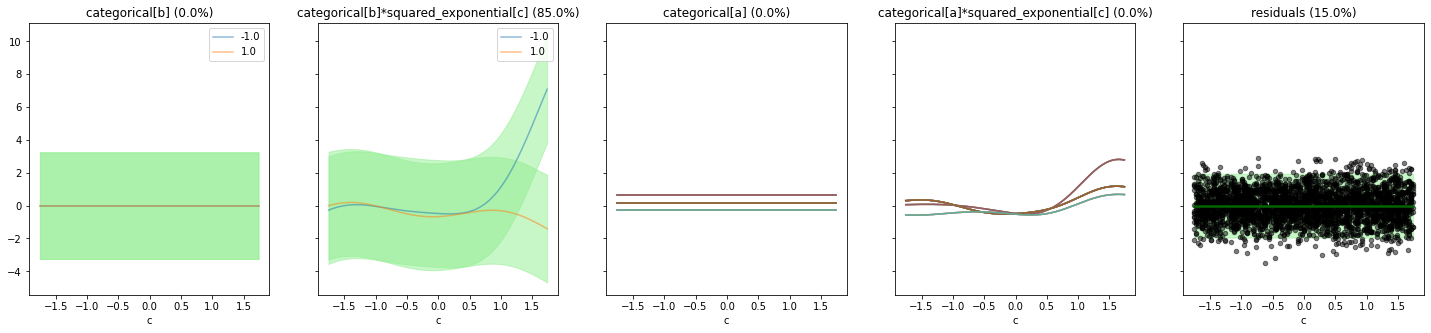

In [79]:
pred_kernel_parts(
    m=m_ard,
    k_names="categorical[1]+categorical[1]*squared_exponential[2]+categorical[0]+categorical[0]*squared_exponential[2]",
    unit_idx=0,
    time_idx=2,
    col_names=['a', 'b', 'c']
)

### LASSO prefiltering

In [72]:
m_lasso = gpflow.models.GPR(
    data=(X_test, Y_test),
    kernel=gpflow.kernels.Sum([gpflow.kernels.SquaredExponential(active_dims=[x]) for x in range(3)])
)
# Set priors
for p in m_lasso.kernel.parameters:
    p.prior = tfd.Laplace(f64(0), f64(1))

In [73]:
print_summary(m_lasso)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │       1 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │       1 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │       1 │
├───────

In [74]:
opt_results = gpflow.optimizers.Scipy().minimize(
    m_lassoå.training_loss,
    m_lasso.trainable_variables
)

In [76]:
print_summary(m_lasso)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │ 1.51376     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ float64 │ 0.00623874  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │ Laplace │ True        │ ()      │ 

### Adding Priors

In [16]:
samp_df

id  treat  time        y1        y2        y3         y4
0     0.0    0.0   0.8 -0.403505 -1.740430  0.219321   1.558011
1     0.0    0.0   1.0 -0.384368 -2.016143  0.306913   2.082773
2     0.0    0.0   1.5 -1.146688 -1.203751  0.571485   1.434307
3     0.0    0.0   2.7  0.143024 -2.152576  0.915007   0.713268
4     0.0    0.0   2.8  0.566962 -2.382068  1.091982   0.837487
..    ...    ...   ...       ...       ...       ...        ...
995  49.0    1.0   9.5 -0.388479 -3.050735 -1.324360  11.831224
996  49.0    1.0  10.1  1.039816 -2.195747 -1.469057  13.943111
997  49.0    1.0  10.8  0.680261 -0.306518 -1.654922  16.570543
998  49.0    1.0  11.4  0.141867 -1.354302 -1.834372  21.272711
999  49.0    1.0  11.8  0.857068 -1.753086 -1.627686  24.615195

[1000 rows x 7 columns]

In [18]:
k4

<gpflow.kernels.base.Sum object at 0x2800e9610>
╒════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                   │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance                │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  0.5    │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  0.0001 │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  1      │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].kernels[1].offset       │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  6      │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[2].kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  1      │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[2].kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  1      │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[2].kernels[1].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  0.5    │
╘════════════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛

In [28]:
%%time
k = (Categorical(active_dims=[0]) + 
    Categorical(active_dims=[1])*gpflow.kernels.Polynomial(active_dims=[2]) + 
    Categorical(active_dims=[0])*gpflow.kernels.SquaredExponential(active_dims=[2]))
m_orig = kernel_test(
    X=samp_df[['id', 'treat', 'time']].to_numpy().reshape(-1, 3),
    Y=samp_df['y4'].to_numpy().reshape(-1, 1),
    k=k)

CPU times: user 41.6 s, sys: 8.84 s, total: 50.4 s
Wall time: 24.7 s


In [29]:
%%time
# Add priors
for p in k.parameters:
    p.prior = tfd.Gamma(f64(1),f64(1))
    
m_prior = kernel_test(
    X=samp_df[['id', 'treat', 'time']].to_numpy().reshape(-1, 3),
    Y=samp_df['y4'].to_numpy().reshape(-1, 1),
    k=k)

CPU times: user 53 s, sys: 10.6 s, total: 1min 3s
Wall time: 23.8 s


In [30]:
m_orig

(<gpflow.models.gpr.GPR object at 0x2861dc4c0>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.461597 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.419214 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│

In [31]:
m_prior

(<gpflow.models.gpr.GPR object at 0x28a6dec40>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.449698  │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.140887  │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────